In [2]:
import os
import random

import torch
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

from tqdm import tqdm   # show loops progress

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version from PyTorch: {torch.version.cuda}")

PyTorch version: 2.5.1
CUDA version from PyTorch: 12.1


In [4]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti SUPER


**SEED**

In [5]:
SEED:int = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**LOAD TRAIN DATA**

In [6]:
# Dataset personalizado para DRIVE
class Dataset(Dataset):
    def __init__(self, image_dir, ground_truth, transform=None, transform_img=None):
        self.image_dir = image_dir
        self.ground_truth_dir = ground_truth
        self.image_filenames = os.listdir(image_dir)  
        self.mask_filenames = os.listdir(ground_truth)   
        self.transform = transform
        self.transform_img = transform_img

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        ground_truth_path = os.path.join(self.ground_truth_dir, self.mask_filenames[idx])
        
        image = Image.open(image_path).convert('RGB')
        ground_truth = Image.open(ground_truth_path).convert('L')  # gt to grayscale
        
        # image to tensor (needed to concatenate and more)
        image = transforms.ToTensor()(image)
        ground_truth = transforms.ToTensor()(ground_truth)
        
        if self.transform:        # exactly same transformations to image and gt
            # Concatenate along channel dimension.
            # Here, dim=0 is the channel dimension (not the batch dim) (here we have [C, H, W])
            image_and_gt = torch.cat([image, ground_truth], dim=0) 
            
            # Transform together
            transformed = self.transform(image_and_gt)

            # Slice the tensors out
            image = transformed[:3, :, :]    
            ground_truth = (transformed[3:, :, :] > 0.5).float()       # binarize !!!
        
        
        if self.transform_img:       # transformations only for images
            image = self.transform_img(image)
            

        return image, ground_truth, self.image_filenames[idx]

In [7]:
# Routes for training data
image_dir = './data/CHASE/training/images'
ground_truth_dir = './data/CHASE/training/2nd_manual'

''' # Just compute the mean and std
from torchvision import datasets
# calculate mean and std
dataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

NORM_MEAN = 0.
NORM_STD = 0.
for images, _, _ in dataloader:
    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)
    NORM_STD += images.std([0, 2, 3])    # channels std

NORM_MEAN /= len(dataloader)
NORM_STD /= len(dataloader)

print(f"Mean: {NORM_MEAN}")
print(f"Std: {NORM_STD}")'''

' # Just compute the mean and std\nfrom torchvision import datasets\n# calculate mean and std\ndataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)\n\nNORM_MEAN = 0.\nNORM_STD = 0.\nfor images, _, _ in dataloader:\n    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)\n    NORM_STD += images.std([0, 2, 3])    # channels std\n\nNORM_MEAN /= len(dataloader)\nNORM_STD /= len(dataloader)\n\nprint(f"Mean: {NORM_MEAN}")\nprint(f"Std: {NORM_STD}")'

In [8]:
IMG_SIZE:int = 512
DATA_AUG_PROB:float = 0.85

from torchvision.transforms import v2

# transforms for images and its ground truth segmentations (same for both)
transform = v2.Compose([
    v2.RandomApply([
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        #v2.RandomZoomOut(fill=0, p=0.2), 
        v2.RandomAffine(degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.5, 1.5)),
        #v2.RandomResizedCrop(IMG_SIZE),
        #v2.ElasticTransform(alpha=15.0),
        #v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
        
    ], p=DATA_AUG_PROB),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    
    # transforms.Grayscale(num_output_channels=1),       # we want rgb    
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])

# transform just for the image
transform_img = v2.Compose([
    v2.RandomApply([
        v2.ColorJitter(brightness=[0.6, 1.2], contrast=[0.3, 1.3], saturation=[0.5, 1.3], hue=0.015),
        v2.RandomAdjustSharpness(sharpness_factor=1.5),
        #v2.GaussianNoise(),

    ], p=DATA_AUG_PROB),
     
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])


dataset = Dataset(image_dir, ground_truth_dir, transform=transform, transform_img=transform_img)

In [9]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)
for img, gt, _ in example_loader:
    print(img.shape)
    print(gt.shape)
    print("\n")
    break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])




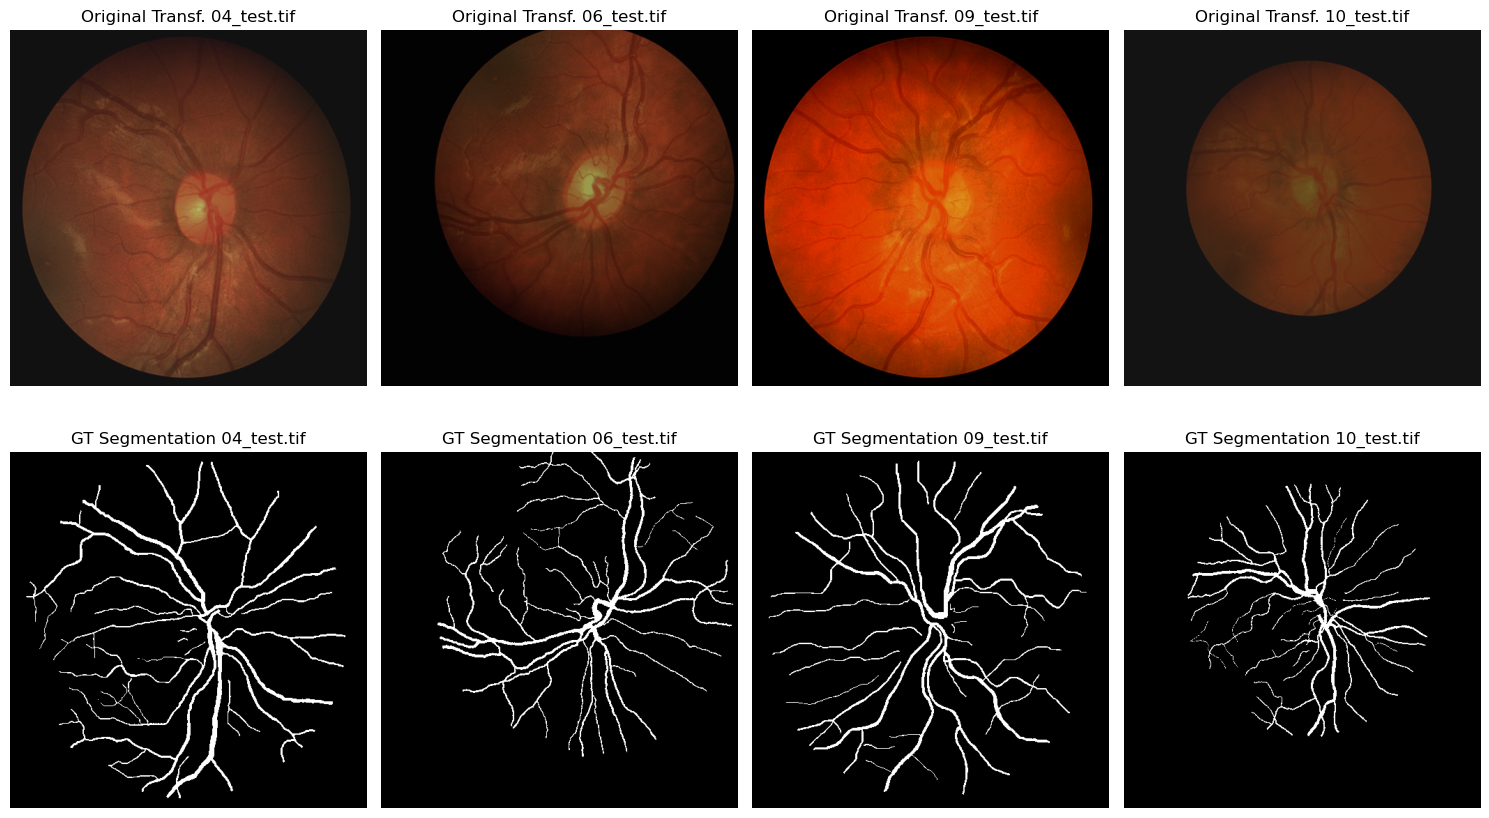

In [10]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# Obtener algunas imágenes y máscaras del example_loader
data_iter = iter(example_loader)
images, ground_truth, img_name = next(data_iter)

# Convertir los tensores a formato numpy para visualizarlos
images = images.numpy().transpose(0, 2, 3, 1)  # [N, C, H, W] a [N, H, W, C]
ground_truth = ground_truth.numpy()  # [N, H, W] para las máscaras

# Eliminar la dimensión extra (1, H, W) de las máscaras
ground_truth = np.squeeze(ground_truth)  # Esto convierte la forma (1, H, W) a (H, W)

# Visualizar las imágenes en la fila superior y las máscaras en la fila inferior
fig, axes = plt.subplots(2, 4, figsize=(15, 9))  # 2 filas, 4 columnas (imágenes arriba y máscaras abajo)

for i in range(4):
    # Mostrar la imagen en la fila superior
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original Transf. {img_name[i]}')
    
    # Mostrar la máscara en la fila inferior
    axes[1, i].imshow(ground_truth[i], cmap='gray')  # show as grayscale
    axes[1, i].axis('off')
    axes[1, i].set_title(f'GT Segmentation {img_name[i]}')

plt.tight_layout()
plt.show()

**DATA SPLITTING**

In [11]:
VAL_PERCENT:float = 0.1            # Percentage of dataset intended for validation (rest is for training) 
BATCH_SIZE:int = 4

# Split into train / validation partitions
val_size = int(len(dataset) * VAL_PERCENT)     # number of samples for validation
train_size = len(dataset) - val_size           # number of samples for training
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print('Training set has {} instances'.format(train_size))
print('Validation set has {} instances'.format(val_size))

Training set has 18 instances
Validation set has 2 instances


In [12]:
sample_image, sample_gt, _ = train_set[0]

NUM_CHANNELS_IN:int = sample_image.size(0)  
NUM_CHANNELS_OUT:int = sample_gt.size(0)

print(f"Number of channels in input: {NUM_CHANNELS_IN}")
print(f"Number of channels in output: {NUM_CHANNELS_OUT}")

Number of channels in input: 3
Number of channels in output: 1


**CREATE MODEL**

In [13]:
# from unet import UNet
# model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)

# from vig import ViGClassifier
# NUM_PATCHES:int = 196    #196
# PATCH_SIZE:int = int(IMG_SIZE//np.sqrt(NUM_PATCHES))
# print(f"{PATCH_SIZE=}")
# model = ViGClassifier(in_features = NUM_CHANNELS_IN * PATCH_SIZE * PATCH_SIZE,       # size of each input patch
#                    n_classes = NUM_CHANNELS_OUT,                                  # number of classes to predict
#                    num_patches = NUM_PATCHES,                                      
#                    patch_size = PATCH_SIZE,
#                    output_size = IMG_SIZE,
#                    out_feature = 192,                                             # features per node/patch (tiny: 192 |small: 320 |base: 640)
#                    num_ViGBlocks=12,                                              # number of Grapher module + FFN (tiny: 12 |small: 16 |base: 16)
#                    hidden_layer=1024,
#                    num_edges=7,                                                   # number of neigbours per node
#                    head_num=2,
#                   )


from vig_unet import ViGUNet
NUM_PATCHES:int = 14*14   #196         # ONLY PERFECT SQUARES
PATCH_SIZE:int = int(IMG_SIZE//np.sqrt(NUM_PATCHES))
model = ViGUNet(n_channels = NUM_CHANNELS_IN,
                n_classes = NUM_CHANNELS_OUT,                 # number of classes to predict
                in_features = NUM_CHANNELS_IN * PATCH_SIZE * PATCH_SIZE,       # size of each input patch
                out_feature = 192,                                             # features per node/patch (tiny: 192 |small: 320 |base: 640)
                num_patches = NUM_PATCHES,
                num_ViGBlocks = 12,                                              # number of Grapher module + FFN (tiny: 12 |small: 16 |base: 16)                                      
                num_edges = 9,   #9                                              # number of neigbours per node
                head_num = 1,    #1
                patch_size = PATCH_SIZE,
                output_size = IMG_SIZE,
                )


# cuda if available, cpu if not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device.type=}")
model.to(device)      # move to cuda if possible

#from torchsummary import summary
#summary(model, (NUM_CHANNELS_IN, IMG_SIZE, IMG_SIZE))

device.type='cuda'


ViGUNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128

**SOME HYPERPARAMETERS, SAVE PATH, CUDA**

In [14]:
EPOCHS:int = 1250

# save best model state path
SAVE_PATH = "./trained_models"
       

# LOSS FUNCTION -----------------------------------------------------
from utils.loss_functions import DiceLoss, DiceBCELoss, DiceBCELossWithTopology
#(need sigmoid at the end of network)

#loss_fn = torch.nn.BCELoss()        # binary cross-entropy loss 
#loss_fn = DiceLoss()
loss_fn = DiceBCELoss(bce_weight=0.5)      # weight of BCE
#loss_fn = DiceBCELossWithTopology(bce_weight=0.5, topology_weight=0.25, image_pixels=IMG_SIZE*IMG_SIZE)


# OPTIMIZER ---------------------------------------------------------
LEARNING_RATE:float = 0.001
MOMENTUM:float = 0.9
WEIGHT_DECAY:float = 1e-2

#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

optimizer = torch.optim.AdamW([
    {'params': model.parameters()},  # Parámetros del modelo
    {'params': loss_fn.parameters()}  # Parámetros de la pérdida
], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

**TRAIN FUNCTION**

In [16]:
def training_loop(epochs, model, train_dataloader, val_dataloader, 
                  loss_fn, optimizer, save_path, patience=30):
    
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy':[], 'val_accuracy':[]}
    best_val_loss = float('inf')  # Initialize to infinity
    best_model_state = None
    datetime_start = datetime.now()
    
    early_stopping_counter = 0  # Counter for early stopping

    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0
        train_correct_pred = 0
        total_train_pred = 0
        
        for data in tqdm(train_dataloader):      # for each training batch
            
            img, ground_truth, _ = data
            img, ground_truth = img.to(device), ground_truth.to(device)     # move to cuda, if possible
            
            pred = model(img)
            # print(f"Pred shape: {pred.shape}, Ground truth shape: {ground_truth.shape}")   # debug
            # print(torch.max(pred))
            # print(torch.min(pred))
            # print(f"Pred device: {pred.device}, Ground truth device: {ground_truth.device}")
            # print(f"Pred type: {type(pred)}")
            # print(f"Pred content: {pred}")

            # print(f"Ground truth values: {ground_truth.unique()}")
            # print("\n")

            loss = loss_fn(pred, ground_truth)
            # print(loss)
            # print(loss.shape)
            running_train_loss += loss.item()
            train_correct_pred += ((pred > 0.5).float() == ground_truth).sum()      # add number of correct predictions
            total_train_pred += IMG_SIZE*IMG_SIZE*len(img)            # add number of predictions made (pixels per img * number of imgs)
            
            loss.backward()            # calculate gradients
            optimizer.step()           # update model parameters
            optimizer.zero_grad()      # reset gradients
        
        model.eval()
        with torch.no_grad():
            running_val_loss = 0
            val_correct_pred = 0
            total_val_pred = 0
            
            for data in tqdm(val_dataloader):      # for each validation batch
                
                img, ground_truth, _ = data
                img, ground_truth = img.to(device), ground_truth.to(device)       # move to cuda, if possible
                
                pred = model(img)
                loss = loss_fn(pred, ground_truth)
                
                running_val_loss += loss.item()
                val_correct_pred += ((pred > 0.5).float() == ground_truth).sum()         # add number of correct predictions
                total_val_pred += IMG_SIZE*IMG_SIZE*len(img)                     # add number of predictions made (pixels per img * number of imgs)


        train_loss = running_train_loss / len(train_dataloader.dataset)
        val_loss = running_val_loss / len(val_dataloader.dataset)
        train_acc = train_correct_pred / total_train_pred * 100       # % of average accuracy in training, in this epoch
        val_acc = val_correct_pred / total_val_pred * 100             # % of average accuracy in validation, in this epoch

        history['train_loss'].append(train_loss)         # add metrics in this epoch to the record
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss:.5f} | Validation loss: {val_loss:.5f} | Training accuracy: {train_acc:.2f}% | Validation accuracy: {val_acc:.2f}%')
        print(f"\n")
        
        # Save the model if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the model state
            early_stopping_counter = 0   # Reset counter if validation loss improves
        else:
            early_stopping_counter += 1
            print(f"Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{patience}")
        
        # Stop training if patience is exceeded
        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break
        
    # Save the best model state
    if best_model_state is not None:
        model_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)
        torch.save(best_model_state, model_path)    
        print(f'Best model saved at {model_path}')
    
    # save history (dictionary)
    history_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)+'_history'
    torch.save(history, history_path)
    print(f'\nHistory saved at {history_path}')
    
    model.eval()
    return history

In [15]:
# TRAIN THE CURRENT MODEL
start_time = datetime.now()

PATIENCE = 100

history = training_loop(EPOCHS, model, train_loader, val_loader, 
                        loss_fn, optimizer, SAVE_PATH, PATIENCE)

end_time = datetime.now()
print(f"\nTraining duration: {end_time - start_time}")

100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


Epoch: 1/1250 | Training loss: 0.33380 | Validation loss: 0.58231 | Training accuracy: 92.47% | Validation accuracy: 89.48%




100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


Epoch: 2/1250 | Training loss: 0.33365 | Validation loss: 0.63056 | Training accuracy: 93.15% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Epoch: 3/1250 | Training loss: 0.33456 | Validation loss: 0.57771 | Training accuracy: 93.60% | Validation accuracy: 91.70%




100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


Epoch: 4/1250 | Training loss: 0.33431 | Validation loss: 0.59677 | Training accuracy: 94.07% | Validation accuracy: 94.84%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


Epoch: 5/1250 | Training loss: 0.32818 | Validation loss: 0.62861 | Training accuracy: 93.32% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


Epoch: 6/1250 | Training loss: 0.32086 | Validation loss: 0.59510 | Training accuracy: 92.68% | Validation accuracy: 93.68%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Epoch: 7/1250 | Training loss: 0.32058 | Validation loss: 0.55048 | Training accuracy: 93.85% | Validation accuracy: 96.87%




100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


Epoch: 8/1250 | Training loss: 0.31412 | Validation loss: 0.52885 | Training accuracy: 93.18% | Validation accuracy: 93.56%




100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


Epoch: 9/1250 | Training loss: 0.31099 | Validation loss: 0.55915 | Training accuracy: 93.82% | Validation accuracy: 92.37%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


Epoch: 10/1250 | Training loss: 0.30766 | Validation loss: 0.55035 | Training accuracy: 94.54% | Validation accuracy: 94.31%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


Epoch: 11/1250 | Training loss: 0.30047 | Validation loss: 0.56406 | Training accuracy: 94.82% | Validation accuracy: 92.92%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


Epoch: 12/1250 | Training loss: 0.28653 | Validation loss: 0.53714 | Training accuracy: 92.70% | Validation accuracy: 92.94%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


Epoch: 13/1250 | Training loss: 0.28111 | Validation loss: 0.54434 | Training accuracy: 92.94% | Validation accuracy: 94.67%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Epoch: 14/1250 | Training loss: 0.26928 | Validation loss: 0.50766 | Training accuracy: 93.33% | Validation accuracy: 93.25%




100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Epoch: 15/1250 | Training loss: 0.26118 | Validation loss: 0.49551 | Training accuracy: 92.63% | Validation accuracy: 94.56%




100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Epoch: 16/1250 | Training loss: 0.24880 | Validation loss: 0.51814 | Training accuracy: 93.32% | Validation accuracy: 94.50%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Epoch: 17/1250 | Training loss: 0.24360 | Validation loss: 0.47718 | Training accuracy: 94.13% | Validation accuracy: 94.19%




100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Epoch: 18/1250 | Training loss: 0.22892 | Validation loss: 0.48830 | Training accuracy: 92.93% | Validation accuracy: 92.01%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


Epoch: 19/1250 | Training loss: 0.21923 | Validation loss: 0.48488 | Training accuracy: 93.36% | Validation accuracy: 94.20%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


Epoch: 20/1250 | Training loss: 0.21330 | Validation loss: 0.42594 | Training accuracy: 94.75% | Validation accuracy: 93.67%




100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


Epoch: 21/1250 | Training loss: 0.20186 | Validation loss: 0.41612 | Training accuracy: 92.88% | Validation accuracy: 94.81%




100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


Epoch: 22/1250 | Training loss: 0.20290 | Validation loss: 0.54123 | Training accuracy: 94.19% | Validation accuracy: 92.86%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Epoch: 23/1250 | Training loss: 0.20681 | Validation loss: 0.41102 | Training accuracy: 94.07% | Validation accuracy: 93.00%




100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 24/1250 | Training loss: 0.19428 | Validation loss: 0.37743 | Training accuracy: 93.52% | Validation accuracy: 95.72%




100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 25/1250 | Training loss: 0.18754 | Validation loss: 0.33630 | Training accuracy: 94.26% | Validation accuracy: 94.99%




100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


Epoch: 26/1250 | Training loss: 0.18523 | Validation loss: 0.41238 | Training accuracy: 93.97% | Validation accuracy: 93.14%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


Epoch: 27/1250 | Training loss: 0.18521 | Validation loss: 0.45349 | Training accuracy: 94.03% | Validation accuracy: 91.79%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


Epoch: 28/1250 | Training loss: 0.19333 | Validation loss: 0.44639 | Training accuracy: 92.05% | Validation accuracy: 94.59%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Epoch: 29/1250 | Training loss: 0.18536 | Validation loss: 0.49629 | Training accuracy: 93.79% | Validation accuracy: 94.12%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


Epoch: 30/1250 | Training loss: 0.18232 | Validation loss: 0.35047 | Training accuracy: 94.26% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Epoch: 31/1250 | Training loss: 0.18201 | Validation loss: 0.36155 | Training accuracy: 93.98% | Validation accuracy: 93.32%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


Epoch: 32/1250 | Training loss: 0.18373 | Validation loss: 0.31157 | Training accuracy: 92.80% | Validation accuracy: 93.40%




100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


Epoch: 33/1250 | Training loss: 0.17688 | Validation loss: 0.33948 | Training accuracy: 94.04% | Validation accuracy: 92.22%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Epoch: 34/1250 | Training loss: 0.18351 | Validation loss: 0.32749 | Training accuracy: 94.33% | Validation accuracy: 92.70%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


Epoch: 35/1250 | Training loss: 0.17861 | Validation loss: 0.40315 | Training accuracy: 94.32% | Validation accuracy: 93.28%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


Epoch: 36/1250 | Training loss: 0.18838 | Validation loss: 0.32951 | Training accuracy: 92.71% | Validation accuracy: 93.52%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


Epoch: 37/1250 | Training loss: 0.17672 | Validation loss: 0.40722 | Training accuracy: 93.68% | Validation accuracy: 90.19%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


Epoch: 38/1250 | Training loss: 0.17541 | Validation loss: 0.33696 | Training accuracy: 93.39% | Validation accuracy: 94.16%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


Epoch: 39/1250 | Training loss: 0.17531 | Validation loss: 0.37360 | Training accuracy: 94.88% | Validation accuracy: 95.54%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


Epoch: 40/1250 | Training loss: 0.17769 | Validation loss: 0.30586 | Training accuracy: 93.21% | Validation accuracy: 92.60%




100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


Epoch: 41/1250 | Training loss: 0.17850 | Validation loss: 0.45267 | Training accuracy: 93.36% | Validation accuracy: 93.82%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


Epoch: 42/1250 | Training loss: 0.17577 | Validation loss: 0.30421 | Training accuracy: 95.40% | Validation accuracy: 94.81%




100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Epoch: 43/1250 | Training loss: 0.17207 | Validation loss: 0.29565 | Training accuracy: 96.26% | Validation accuracy: 95.66%




100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


Epoch: 44/1250 | Training loss: 0.17171 | Validation loss: 0.29409 | Training accuracy: 95.27% | Validation accuracy: 96.60%




100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Epoch: 45/1250 | Training loss: 0.16925 | Validation loss: 0.29733 | Training accuracy: 96.44% | Validation accuracy: 98.42%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Epoch: 46/1250 | Training loss: 0.17435 | Validation loss: 0.34171 | Training accuracy: 94.98% | Validation accuracy: 94.40%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


Epoch: 47/1250 | Training loss: 0.17129 | Validation loss: 0.31764 | Training accuracy: 95.81% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Epoch: 48/1250 | Training loss: 0.17129 | Validation loss: 0.36594 | Training accuracy: 95.53% | Validation accuracy: 94.13%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Epoch: 49/1250 | Training loss: 0.16987 | Validation loss: 0.29419 | Training accuracy: 96.03% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


Epoch: 50/1250 | Training loss: 0.16880 | Validation loss: 0.28519 | Training accuracy: 95.39% | Validation accuracy: 96.39%




100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


Epoch: 51/1250 | Training loss: 0.16757 | Validation loss: 0.31148 | Training accuracy: 95.97% | Validation accuracy: 95.15%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Epoch: 52/1250 | Training loss: 0.17774 | Validation loss: 0.30596 | Training accuracy: 94.82% | Validation accuracy: 98.55%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


Epoch: 53/1250 | Training loss: 0.16802 | Validation loss: 0.33638 | Training accuracy: 96.76% | Validation accuracy: 96.06%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


Epoch: 54/1250 | Training loss: 0.16724 | Validation loss: 0.32192 | Training accuracy: 95.74% | Validation accuracy: 95.70%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Epoch: 55/1250 | Training loss: 0.16775 | Validation loss: 0.28425 | Training accuracy: 95.62% | Validation accuracy: 96.60%




100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


Epoch: 56/1250 | Training loss: 0.16534 | Validation loss: 0.39009 | Training accuracy: 95.96% | Validation accuracy: 92.08%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


Epoch: 57/1250 | Training loss: 0.16532 | Validation loss: 0.30892 | Training accuracy: 96.39% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Epoch: 58/1250 | Training loss: 0.16897 | Validation loss: 0.29654 | Training accuracy: 96.46% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


Epoch: 59/1250 | Training loss: 0.16217 | Validation loss: 0.33537 | Training accuracy: 96.34% | Validation accuracy: 94.35%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


Epoch: 60/1250 | Training loss: 0.16686 | Validation loss: 0.39095 | Training accuracy: 95.74% | Validation accuracy: 92.85%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


Epoch: 61/1250 | Training loss: 0.16664 | Validation loss: 0.28982 | Training accuracy: 95.22% | Validation accuracy: 96.27%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


Epoch: 62/1250 | Training loss: 0.16033 | Validation loss: 0.30064 | Training accuracy: 96.30% | Validation accuracy: 95.75%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


Epoch: 63/1250 | Training loss: 0.16295 | Validation loss: 0.30205 | Training accuracy: 96.36% | Validation accuracy: 95.08%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 64/1250 | Training loss: 0.16030 | Validation loss: 0.28287 | Training accuracy: 96.34% | Validation accuracy: 95.81%




100%|██████████| 1/1 [00:00<00:00,  7.77it/s]


Epoch: 65/1250 | Training loss: 0.16025 | Validation loss: 0.32708 | Training accuracy: 95.84% | Validation accuracy: 94.85%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Epoch: 66/1250 | Training loss: 0.15941 | Validation loss: 0.30290 | Training accuracy: 96.72% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Epoch: 67/1250 | Training loss: 0.16047 | Validation loss: 0.34476 | Training accuracy: 95.49% | Validation accuracy: 94.86%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 68/1250 | Training loss: 0.16527 | Validation loss: 0.32424 | Training accuracy: 95.79% | Validation accuracy: 94.33%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Epoch: 69/1250 | Training loss: 0.15975 | Validation loss: 0.33370 | Training accuracy: 96.22% | Validation accuracy: 93.64%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


Epoch: 70/1250 | Training loss: 0.15959 | Validation loss: 0.29189 | Training accuracy: 96.12% | Validation accuracy: 96.55%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


Epoch: 71/1250 | Training loss: 0.15797 | Validation loss: 0.28416 | Training accuracy: 95.96% | Validation accuracy: 96.18%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


Epoch: 72/1250 | Training loss: 0.15644 | Validation loss: 0.29062 | Training accuracy: 96.46% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Epoch: 73/1250 | Training loss: 0.16026 | Validation loss: 0.29204 | Training accuracy: 96.02% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


Epoch: 74/1250 | Training loss: 0.15640 | Validation loss: 0.31412 | Training accuracy: 95.78% | Validation accuracy: 95.37%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


Epoch: 75/1250 | Training loss: 0.15698 | Validation loss: 0.28043 | Training accuracy: 96.21% | Validation accuracy: 98.18%




100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


Epoch: 76/1250 | Training loss: 0.15722 | Validation loss: 0.27468 | Training accuracy: 96.49% | Validation accuracy: 96.41%




100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Epoch: 77/1250 | Training loss: 0.15438 | Validation loss: 0.31220 | Training accuracy: 95.96% | Validation accuracy: 94.46%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Epoch: 78/1250 | Training loss: 0.15601 | Validation loss: 0.26516 | Training accuracy: 96.00% | Validation accuracy: 97.15%




100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


Epoch: 79/1250 | Training loss: 0.15271 | Validation loss: 0.27322 | Training accuracy: 96.70% | Validation accuracy: 95.36%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


Epoch: 80/1250 | Training loss: 0.15258 | Validation loss: 0.31274 | Training accuracy: 95.91% | Validation accuracy: 94.57%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


Epoch: 81/1250 | Training loss: 0.15430 | Validation loss: 0.26662 | Training accuracy: 96.02% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epoch: 82/1250 | Training loss: 0.15270 | Validation loss: 0.27892 | Training accuracy: 96.25% | Validation accuracy: 94.97%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 83/1250 | Training loss: 0.15292 | Validation loss: 0.27723 | Training accuracy: 96.32% | Validation accuracy: 95.74%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


Epoch: 84/1250 | Training loss: 0.15438 | Validation loss: 0.28875 | Training accuracy: 95.82% | Validation accuracy: 95.19%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


Epoch: 85/1250 | Training loss: 0.15125 | Validation loss: 0.35233 | Training accuracy: 96.47% | Validation accuracy: 93.66%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Epoch: 86/1250 | Training loss: 0.15223 | Validation loss: 0.29389 | Training accuracy: 96.20% | Validation accuracy: 95.20%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


Epoch: 87/1250 | Training loss: 0.15211 | Validation loss: 0.33739 | Training accuracy: 95.74% | Validation accuracy: 93.95%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Epoch: 88/1250 | Training loss: 0.15096 | Validation loss: 0.28116 | Training accuracy: 96.01% | Validation accuracy: 95.43%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


Epoch: 89/1250 | Training loss: 0.15035 | Validation loss: 0.26560 | Training accuracy: 96.03% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


Epoch: 90/1250 | Training loss: 0.15114 | Validation loss: 0.27169 | Training accuracy: 95.73% | Validation accuracy: 95.56%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


Epoch: 91/1250 | Training loss: 0.14801 | Validation loss: 0.25973 | Training accuracy: 96.25% | Validation accuracy: 98.43%




100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


Epoch: 92/1250 | Training loss: 0.14711 | Validation loss: 0.29197 | Training accuracy: 96.79% | Validation accuracy: 95.99%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Epoch: 93/1250 | Training loss: 0.14931 | Validation loss: 0.26980 | Training accuracy: 95.85% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


Epoch: 94/1250 | Training loss: 0.14889 | Validation loss: 0.26242 | Training accuracy: 96.27% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


Epoch: 95/1250 | Training loss: 0.14943 | Validation loss: 0.28092 | Training accuracy: 96.00% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Epoch: 96/1250 | Training loss: 0.14709 | Validation loss: 0.26106 | Training accuracy: 96.15% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Epoch: 97/1250 | Training loss: 0.14899 | Validation loss: 0.26963 | Training accuracy: 95.50% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


Epoch: 98/1250 | Training loss: 0.14596 | Validation loss: 0.26290 | Training accuracy: 96.50% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


Epoch: 99/1250 | Training loss: 0.14704 | Validation loss: 0.25950 | Training accuracy: 96.22% | Validation accuracy: 96.14%




100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


Epoch: 100/1250 | Training loss: 0.14488 | Validation loss: 0.26468 | Training accuracy: 96.47% | Validation accuracy: 95.80%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Epoch: 101/1250 | Training loss: 0.14614 | Validation loss: 0.24977 | Training accuracy: 96.21% | Validation accuracy: 97.20%




100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


Epoch: 102/1250 | Training loss: 0.14408 | Validation loss: 0.26773 | Training accuracy: 96.73% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


Epoch: 103/1250 | Training loss: 0.14588 | Validation loss: 0.26054 | Training accuracy: 96.11% | Validation accuracy: 95.40%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Epoch: 104/1250 | Training loss: 0.14342 | Validation loss: 0.24631 | Training accuracy: 96.55% | Validation accuracy: 97.62%




100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


Epoch: 105/1250 | Training loss: 0.14554 | Validation loss: 0.24410 | Training accuracy: 96.02% | Validation accuracy: 97.60%




100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


Epoch: 106/1250 | Training loss: 0.14261 | Validation loss: 0.26474 | Training accuracy: 96.42% | Validation accuracy: 95.26%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


Epoch: 107/1250 | Training loss: 0.14288 | Validation loss: 0.25849 | Training accuracy: 96.64% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


Epoch: 108/1250 | Training loss: 0.14173 | Validation loss: 0.24728 | Training accuracy: 96.47% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Epoch: 109/1250 | Training loss: 0.14049 | Validation loss: 0.29002 | Training accuracy: 96.90% | Validation accuracy: 94.46%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


Epoch: 110/1250 | Training loss: 0.14302 | Validation loss: 0.25959 | Training accuracy: 96.90% | Validation accuracy: 95.54%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


Epoch: 111/1250 | Training loss: 0.13986 | Validation loss: 0.29740 | Training accuracy: 96.78% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


Epoch: 112/1250 | Training loss: 0.14143 | Validation loss: 0.24909 | Training accuracy: 96.67% | Validation accuracy: 98.39%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


Epoch: 113/1250 | Training loss: 0.14081 | Validation loss: 0.25646 | Training accuracy: 96.51% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


Epoch: 114/1250 | Training loss: 0.14468 | Validation loss: 0.25166 | Training accuracy: 96.40% | Validation accuracy: 98.67%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Epoch: 115/1250 | Training loss: 0.14916 | Validation loss: 0.24430 | Training accuracy: 95.78% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


Epoch: 116/1250 | Training loss: 0.14605 | Validation loss: 0.46649 | Training accuracy: 96.16% | Validation accuracy: 92.12%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


Epoch: 117/1250 | Training loss: 0.14779 | Validation loss: 0.51046 | Training accuracy: 96.32% | Validation accuracy: 92.31%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.80it/s]


Epoch: 118/1250 | Training loss: 0.14688 | Validation loss: 0.24872 | Training accuracy: 95.95% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


Epoch: 119/1250 | Training loss: 0.15154 | Validation loss: 0.26833 | Training accuracy: 95.33% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Epoch: 120/1250 | Training loss: 0.15009 | Validation loss: 0.25657 | Training accuracy: 95.99% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Epoch: 121/1250 | Training loss: 0.14796 | Validation loss: 0.33231 | Training accuracy: 95.82% | Validation accuracy: 95.03%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


Epoch: 122/1250 | Training loss: 0.14216 | Validation loss: 0.24713 | Training accuracy: 96.38% | Validation accuracy: 96.49%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


Epoch: 123/1250 | Training loss: 0.15111 | Validation loss: 0.29576 | Training accuracy: 95.75% | Validation accuracy: 95.66%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  7.77it/s]


Epoch: 124/1250 | Training loss: 0.14385 | Validation loss: 0.30711 | Training accuracy: 95.84% | Validation accuracy: 94.36%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


Epoch: 125/1250 | Training loss: 0.14132 | Validation loss: 0.25753 | Training accuracy: 96.06% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


Epoch: 126/1250 | Training loss: 0.14245 | Validation loss: 0.25199 | Training accuracy: 95.98% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Epoch: 127/1250 | Training loss: 0.13916 | Validation loss: 0.24504 | Training accuracy: 96.37% | Validation accuracy: 97.71%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


Epoch: 128/1250 | Training loss: 0.14144 | Validation loss: 0.25304 | Training accuracy: 95.79% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


Epoch: 129/1250 | Training loss: 0.14168 | Validation loss: 0.24407 | Training accuracy: 95.96% | Validation accuracy: 97.50%




100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


Epoch: 130/1250 | Training loss: 0.13846 | Validation loss: 0.24514 | Training accuracy: 96.68% | Validation accuracy: 95.69%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


Epoch: 131/1250 | Training loss: 0.13691 | Validation loss: 0.27160 | Training accuracy: 96.94% | Validation accuracy: 95.76%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


Epoch: 132/1250 | Training loss: 0.13783 | Validation loss: 0.26166 | Training accuracy: 96.17% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.85it/s]


Epoch: 133/1250 | Training loss: 0.13891 | Validation loss: 0.23324 | Training accuracy: 96.37% | Validation accuracy: 97.90%




100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


Epoch: 134/1250 | Training loss: 0.13918 | Validation loss: 0.23688 | Training accuracy: 96.42% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


Epoch: 135/1250 | Training loss: 0.13813 | Validation loss: 0.25203 | Training accuracy: 96.53% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


Epoch: 136/1250 | Training loss: 0.14413 | Validation loss: 0.23337 | Training accuracy: 95.52% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 137/1250 | Training loss: 0.13900 | Validation loss: 0.37293 | Training accuracy: 96.13% | Validation accuracy: 94.24%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Epoch: 138/1250 | Training loss: 0.13913 | Validation loss: 0.23876 | Training accuracy: 96.42% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


Epoch: 139/1250 | Training loss: 0.13808 | Validation loss: 0.30607 | Training accuracy: 97.11% | Validation accuracy: 93.85%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epoch: 140/1250 | Training loss: 0.13650 | Validation loss: 0.27597 | Training accuracy: 96.42% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch: 141/1250 | Training loss: 0.14211 | Validation loss: 0.23359 | Training accuracy: 95.85% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


Epoch: 142/1250 | Training loss: 0.14269 | Validation loss: 0.40477 | Training accuracy: 95.75% | Validation accuracy: 95.76%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


Epoch: 143/1250 | Training loss: 0.13697 | Validation loss: 0.33102 | Training accuracy: 96.25% | Validation accuracy: 95.00%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


Epoch: 144/1250 | Training loss: 0.13809 | Validation loss: 0.24784 | Training accuracy: 96.55% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Epoch: 145/1250 | Training loss: 0.13883 | Validation loss: 0.25822 | Training accuracy: 96.05% | Validation accuracy: 95.58%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


Epoch: 146/1250 | Training loss: 0.14080 | Validation loss: 0.31001 | Training accuracy: 95.60% | Validation accuracy: 94.85%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Epoch: 147/1250 | Training loss: 0.13898 | Validation loss: 0.22895 | Training accuracy: 95.84% | Validation accuracy: 98.22%




100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Epoch: 148/1250 | Training loss: 0.13783 | Validation loss: 0.24740 | Training accuracy: 95.94% | Validation accuracy: 96.18%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


Epoch: 149/1250 | Training loss: 0.13356 | Validation loss: 0.23800 | Training accuracy: 96.72% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Epoch: 150/1250 | Training loss: 0.13362 | Validation loss: 0.23097 | Training accuracy: 96.46% | Validation accuracy: 97.96%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


Epoch: 151/1250 | Training loss: 0.13396 | Validation loss: 0.23920 | Training accuracy: 96.37% | Validation accuracy: 95.47%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch: 152/1250 | Training loss: 0.13246 | Validation loss: 0.23811 | Training accuracy: 96.51% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


Epoch: 153/1250 | Training loss: 0.13046 | Validation loss: 0.27318 | Training accuracy: 96.65% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


Epoch: 154/1250 | Training loss: 0.12932 | Validation loss: 0.22701 | Training accuracy: 96.53% | Validation accuracy: 96.68%




100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


Epoch: 155/1250 | Training loss: 0.12893 | Validation loss: 0.24343 | Training accuracy: 97.01% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 156/1250 | Training loss: 0.13015 | Validation loss: 0.22689 | Training accuracy: 96.40% | Validation accuracy: 96.90%




100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Epoch: 157/1250 | Training loss: 0.13126 | Validation loss: 0.36139 | Training accuracy: 96.34% | Validation accuracy: 95.39%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


Epoch: 158/1250 | Training loss: 0.12819 | Validation loss: 0.21978 | Training accuracy: 97.44% | Validation accuracy: 97.68%




100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Epoch: 159/1250 | Training loss: 0.14095 | Validation loss: 0.23588 | Training accuracy: 95.83% | Validation accuracy: 95.82%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


Epoch: 160/1250 | Training loss: 0.12835 | Validation loss: 0.25037 | Training accuracy: 97.23% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


Epoch: 161/1250 | Training loss: 0.12869 | Validation loss: 0.28089 | Training accuracy: 97.00% | Validation accuracy: 93.97%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


Epoch: 162/1250 | Training loss: 0.12843 | Validation loss: 0.37653 | Training accuracy: 96.41% | Validation accuracy: 94.19%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


Epoch: 163/1250 | Training loss: 0.12740 | Validation loss: 0.23030 | Training accuracy: 96.99% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


Epoch: 164/1250 | Training loss: 0.12889 | Validation loss: 0.23690 | Training accuracy: 96.19% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


Epoch: 165/1250 | Training loss: 0.12670 | Validation loss: 0.23122 | Training accuracy: 96.67% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


Epoch: 166/1250 | Training loss: 0.12551 | Validation loss: 0.25779 | Training accuracy: 96.83% | Validation accuracy: 95.09%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Epoch: 167/1250 | Training loss: 0.12577 | Validation loss: 0.23546 | Training accuracy: 96.60% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


Epoch: 168/1250 | Training loss: 0.12435 | Validation loss: 0.23679 | Training accuracy: 97.07% | Validation accuracy: 95.17%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


Epoch: 169/1250 | Training loss: 0.12934 | Validation loss: 0.23627 | Training accuracy: 95.94% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


Epoch: 170/1250 | Training loss: 0.12568 | Validation loss: 0.24253 | Training accuracy: 96.78% | Validation accuracy: 96.55%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


Epoch: 171/1250 | Training loss: 0.12394 | Validation loss: 0.21463 | Training accuracy: 97.32% | Validation accuracy: 97.72%




100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


Epoch: 172/1250 | Training loss: 0.12985 | Validation loss: 0.28208 | Training accuracy: 96.50% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Epoch: 173/1250 | Training loss: 0.12671 | Validation loss: 0.23225 | Training accuracy: 96.54% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


Epoch: 174/1250 | Training loss: 0.12849 | Validation loss: 0.31048 | Training accuracy: 95.94% | Validation accuracy: 95.45%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


Epoch: 175/1250 | Training loss: 0.12468 | Validation loss: 0.35614 | Training accuracy: 97.06% | Validation accuracy: 94.63%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


Epoch: 176/1250 | Training loss: 0.12760 | Validation loss: 0.23368 | Training accuracy: 96.49% | Validation accuracy: 96.28%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Epoch: 177/1250 | Training loss: 0.12611 | Validation loss: 0.31662 | Training accuracy: 96.74% | Validation accuracy: 92.77%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


Epoch: 178/1250 | Training loss: 0.12700 | Validation loss: 0.24876 | Training accuracy: 96.52% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


Epoch: 179/1250 | Training loss: 0.12638 | Validation loss: 0.21566 | Training accuracy: 96.44% | Validation accuracy: 98.16%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Epoch: 180/1250 | Training loss: 0.12870 | Validation loss: 0.23248 | Training accuracy: 96.08% | Validation accuracy: 95.57%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Epoch: 181/1250 | Training loss: 0.12522 | Validation loss: 0.20879 | Training accuracy: 96.12% | Validation accuracy: 97.75%




100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


Epoch: 182/1250 | Training loss: 0.12549 | Validation loss: 0.21645 | Training accuracy: 96.65% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


Epoch: 183/1250 | Training loss: 0.12404 | Validation loss: 0.23018 | Training accuracy: 96.45% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch: 184/1250 | Training loss: 0.12480 | Validation loss: 0.21845 | Training accuracy: 96.25% | Validation accuracy: 98.38%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


Epoch: 185/1250 | Training loss: 0.12366 | Validation loss: 0.21903 | Training accuracy: 96.94% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


Epoch: 186/1250 | Training loss: 0.12300 | Validation loss: 0.27585 | Training accuracy: 97.45% | Validation accuracy: 95.55%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Epoch: 187/1250 | Training loss: 0.12398 | Validation loss: 0.22292 | Training accuracy: 96.82% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


Epoch: 188/1250 | Training loss: 0.12439 | Validation loss: 0.21001 | Training accuracy: 96.27% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


Epoch: 189/1250 | Training loss: 0.12459 | Validation loss: 0.20679 | Training accuracy: 96.35% | Validation accuracy: 97.88%




100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


Epoch: 190/1250 | Training loss: 0.12150 | Validation loss: 0.23265 | Training accuracy: 96.69% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


Epoch: 191/1250 | Training loss: 0.12133 | Validation loss: 0.20586 | Training accuracy: 96.62% | Validation accuracy: 97.66%




100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Epoch: 192/1250 | Training loss: 0.12000 | Validation loss: 0.22267 | Training accuracy: 96.71% | Validation accuracy: 96.00%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


Epoch: 193/1250 | Training loss: 0.12180 | Validation loss: 0.20434 | Training accuracy: 96.52% | Validation accuracy: 97.40%




100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Epoch: 194/1250 | Training loss: 0.12112 | Validation loss: 0.22927 | Training accuracy: 96.67% | Validation accuracy: 95.58%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


Epoch: 195/1250 | Training loss: 0.12435 | Validation loss: 0.30947 | Training accuracy: 96.40% | Validation accuracy: 95.03%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Epoch: 196/1250 | Training loss: 0.12205 | Validation loss: 0.21292 | Training accuracy: 97.12% | Validation accuracy: 98.39%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Epoch: 197/1250 | Training loss: 0.11972 | Validation loss: 0.23485 | Training accuracy: 96.57% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


Epoch: 198/1250 | Training loss: 0.12255 | Validation loss: 0.20995 | Training accuracy: 96.29% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


Epoch: 199/1250 | Training loss: 0.11953 | Validation loss: 0.21897 | Training accuracy: 96.96% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 200/1250 | Training loss: 0.12106 | Validation loss: 0.21880 | Training accuracy: 96.79% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


Epoch: 201/1250 | Training loss: 0.11980 | Validation loss: 0.23011 | Training accuracy: 96.69% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


Epoch: 202/1250 | Training loss: 0.11772 | Validation loss: 0.20423 | Training accuracy: 97.14% | Validation accuracy: 97.92%




100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Epoch: 203/1250 | Training loss: 0.11967 | Validation loss: 0.29035 | Training accuracy: 96.72% | Validation accuracy: 94.67%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


Epoch: 204/1250 | Training loss: 0.12091 | Validation loss: 0.35924 | Training accuracy: 96.23% | Validation accuracy: 95.48%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


Epoch: 205/1250 | Training loss: 0.11929 | Validation loss: 0.29701 | Training accuracy: 97.09% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


Epoch: 206/1250 | Training loss: 0.11926 | Validation loss: 0.21032 | Training accuracy: 96.83% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch: 207/1250 | Training loss: 0.11826 | Validation loss: 0.32965 | Training accuracy: 96.88% | Validation accuracy: 93.67%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.82it/s]


Epoch: 208/1250 | Training loss: 0.12022 | Validation loss: 0.28756 | Training accuracy: 96.92% | Validation accuracy: 95.09%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Epoch: 209/1250 | Training loss: 0.11967 | Validation loss: 0.20990 | Training accuracy: 97.21% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


Epoch: 210/1250 | Training loss: 0.11825 | Validation loss: 0.34650 | Training accuracy: 96.81% | Validation accuracy: 94.99%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epoch: 211/1250 | Training loss: 0.12164 | Validation loss: 0.20711 | Training accuracy: 97.10% | Validation accuracy: 98.60%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


Epoch: 212/1250 | Training loss: 0.12011 | Validation loss: 0.21831 | Training accuracy: 96.50% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Epoch: 213/1250 | Training loss: 0.11592 | Validation loss: 0.20985 | Training accuracy: 97.20% | Validation accuracy: 97.71%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


Epoch: 214/1250 | Training loss: 0.11739 | Validation loss: 0.21195 | Training accuracy: 97.11% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


Epoch: 215/1250 | Training loss: 0.11834 | Validation loss: 0.21280 | Training accuracy: 96.85% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


Epoch: 216/1250 | Training loss: 0.11619 | Validation loss: 0.20230 | Training accuracy: 97.13% | Validation accuracy: 97.79%




100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 217/1250 | Training loss: 0.11555 | Validation loss: 0.21367 | Training accuracy: 96.99% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


Epoch: 218/1250 | Training loss: 0.11626 | Validation loss: 0.23312 | Training accuracy: 96.75% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Epoch: 219/1250 | Training loss: 0.11535 | Validation loss: 0.23725 | Training accuracy: 96.99% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Epoch: 220/1250 | Training loss: 0.11544 | Validation loss: 0.22572 | Training accuracy: 96.92% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


Epoch: 221/1250 | Training loss: 0.11613 | Validation loss: 0.29057 | Training accuracy: 96.98% | Validation accuracy: 95.14%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 222/1250 | Training loss: 0.11746 | Validation loss: 0.22052 | Training accuracy: 96.49% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


Epoch: 223/1250 | Training loss: 0.11589 | Validation loss: 0.20402 | Training accuracy: 96.51% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


Epoch: 224/1250 | Training loss: 0.11628 | Validation loss: 0.19769 | Training accuracy: 96.66% | Validation accuracy: 98.10%




100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Epoch: 225/1250 | Training loss: 0.11530 | Validation loss: 0.19904 | Training accuracy: 96.79% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


Epoch: 226/1250 | Training loss: 0.11568 | Validation loss: 0.19292 | Training accuracy: 96.87% | Validation accuracy: 97.03%




100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


Epoch: 227/1250 | Training loss: 0.11431 | Validation loss: 0.19971 | Training accuracy: 97.18% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Epoch: 228/1250 | Training loss: 0.11486 | Validation loss: 0.19364 | Training accuracy: 97.14% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 229/1250 | Training loss: 0.11353 | Validation loss: 0.19063 | Training accuracy: 96.81% | Validation accuracy: 97.38%




100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


Epoch: 230/1250 | Training loss: 0.11720 | Validation loss: 0.21776 | Training accuracy: 95.93% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Epoch: 231/1250 | Training loss: 0.11308 | Validation loss: 0.19772 | Training accuracy: 97.18% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Epoch: 232/1250 | Training loss: 0.11431 | Validation loss: 0.20539 | Training accuracy: 96.92% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Epoch: 233/1250 | Training loss: 0.11610 | Validation loss: 0.19562 | Training accuracy: 97.00% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


Epoch: 234/1250 | Training loss: 0.11295 | Validation loss: 0.19580 | Training accuracy: 96.89% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


Epoch: 235/1250 | Training loss: 0.11261 | Validation loss: 0.19424 | Training accuracy: 97.00% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Epoch: 236/1250 | Training loss: 0.11261 | Validation loss: 0.18922 | Training accuracy: 97.07% | Validation accuracy: 97.91%




100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


Epoch: 237/1250 | Training loss: 0.11323 | Validation loss: 0.20682 | Training accuracy: 96.72% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


Epoch: 238/1250 | Training loss: 0.11076 | Validation loss: 0.20085 | Training accuracy: 97.02% | Validation accuracy: 96.08%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 239/1250 | Training loss: 0.11369 | Validation loss: 0.22411 | Training accuracy: 96.45% | Validation accuracy: 95.77%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Epoch: 240/1250 | Training loss: 0.11361 | Validation loss: 0.19952 | Training accuracy: 96.81% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


Epoch: 241/1250 | Training loss: 0.11499 | Validation loss: 0.21585 | Training accuracy: 96.21% | Validation accuracy: 95.94%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Epoch: 242/1250 | Training loss: 0.11141 | Validation loss: 0.19675 | Training accuracy: 97.33% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


Epoch: 243/1250 | Training loss: 0.11349 | Validation loss: 0.21345 | Training accuracy: 96.97% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


Epoch: 244/1250 | Training loss: 0.11307 | Validation loss: 0.21339 | Training accuracy: 96.55% | Validation accuracy: 96.45%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Epoch: 245/1250 | Training loss: 0.11397 | Validation loss: 0.36520 | Training accuracy: 97.09% | Validation accuracy: 94.02%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 246/1250 | Training loss: 0.11279 | Validation loss: 0.22216 | Training accuracy: 96.91% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


Epoch: 247/1250 | Training loss: 0.11317 | Validation loss: 0.20265 | Training accuracy: 97.12% | Validation accuracy: 96.18%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


Epoch: 248/1250 | Training loss: 0.11038 | Validation loss: 0.19165 | Training accuracy: 96.74% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


Epoch: 249/1250 | Training loss: 0.11206 | Validation loss: 0.19567 | Training accuracy: 97.25% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


Epoch: 250/1250 | Training loss: 0.10889 | Validation loss: 0.19902 | Training accuracy: 97.42% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


Epoch: 251/1250 | Training loss: 0.11159 | Validation loss: 0.20086 | Training accuracy: 97.22% | Validation accuracy: 98.55%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


Epoch: 252/1250 | Training loss: 0.10968 | Validation loss: 0.18803 | Training accuracy: 97.14% | Validation accuracy: 97.72%




100%|██████████| 1/1 [00:00<00:00,  9.83it/s]


Epoch: 253/1250 | Training loss: 0.10920 | Validation loss: 0.19028 | Training accuracy: 96.91% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Epoch: 254/1250 | Training loss: 0.11219 | Validation loss: 0.18801 | Training accuracy: 96.47% | Validation accuracy: 98.57%




100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


Epoch: 255/1250 | Training loss: 0.10956 | Validation loss: 0.19774 | Training accuracy: 97.34% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Epoch: 256/1250 | Training loss: 0.10969 | Validation loss: 0.19348 | Training accuracy: 97.49% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


Epoch: 257/1250 | Training loss: 0.10852 | Validation loss: 0.18677 | Training accuracy: 96.78% | Validation accuracy: 98.13%




100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


Epoch: 258/1250 | Training loss: 0.11201 | Validation loss: 0.21270 | Training accuracy: 96.46% | Validation accuracy: 95.49%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


Epoch: 259/1250 | Training loss: 0.11154 | Validation loss: 0.18853 | Training accuracy: 96.51% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Epoch: 260/1250 | Training loss: 0.10842 | Validation loss: 0.18245 | Training accuracy: 97.26% | Validation accuracy: 98.11%




100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


Epoch: 261/1250 | Training loss: 0.10850 | Validation loss: 0.18485 | Training accuracy: 96.87% | Validation accuracy: 98.33%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


Epoch: 262/1250 | Training loss: 0.10644 | Validation loss: 0.20276 | Training accuracy: 97.16% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


Epoch: 263/1250 | Training loss: 0.10678 | Validation loss: 0.21457 | Training accuracy: 96.91% | Validation accuracy: 96.54%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


Epoch: 264/1250 | Training loss: 0.10813 | Validation loss: 0.18590 | Training accuracy: 97.14% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


Epoch: 265/1250 | Training loss: 0.10957 | Validation loss: 0.18738 | Training accuracy: 96.24% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


Epoch: 266/1250 | Training loss: 0.10778 | Validation loss: 0.19170 | Training accuracy: 96.76% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


Epoch: 267/1250 | Training loss: 0.10728 | Validation loss: 0.22130 | Training accuracy: 96.70% | Validation accuracy: 95.65%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Epoch: 268/1250 | Training loss: 0.10741 | Validation loss: 0.18664 | Training accuracy: 96.75% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


Epoch: 269/1250 | Training loss: 0.11143 | Validation loss: 0.18030 | Training accuracy: 96.98% | Validation accuracy: 97.30%




100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


Epoch: 270/1250 | Training loss: 0.10663 | Validation loss: 0.18550 | Training accuracy: 96.67% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


Epoch: 271/1250 | Training loss: 0.10711 | Validation loss: 0.18205 | Training accuracy: 96.92% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


Epoch: 272/1250 | Training loss: 0.10785 | Validation loss: 0.19856 | Training accuracy: 96.90% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


Epoch: 273/1250 | Training loss: 0.10730 | Validation loss: 0.19520 | Training accuracy: 97.21% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


Epoch: 274/1250 | Training loss: 0.10847 | Validation loss: 0.18459 | Training accuracy: 97.02% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Epoch: 275/1250 | Training loss: 0.10908 | Validation loss: 0.19015 | Training accuracy: 96.47% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epoch: 276/1250 | Training loss: 0.10617 | Validation loss: 0.18677 | Training accuracy: 97.07% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Epoch: 277/1250 | Training loss: 0.10713 | Validation loss: 0.18765 | Training accuracy: 96.80% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


Epoch: 278/1250 | Training loss: 0.10815 | Validation loss: 0.20453 | Training accuracy: 96.65% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


Epoch: 279/1250 | Training loss: 0.10831 | Validation loss: 0.19314 | Training accuracy: 96.74% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


Epoch: 280/1250 | Training loss: 0.10665 | Validation loss: 0.20518 | Training accuracy: 96.74% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Epoch: 281/1250 | Training loss: 0.10605 | Validation loss: 0.18384 | Training accuracy: 97.46% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Epoch: 282/1250 | Training loss: 0.10677 | Validation loss: 0.17781 | Training accuracy: 96.90% | Validation accuracy: 97.73%




100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Epoch: 283/1250 | Training loss: 0.10627 | Validation loss: 0.18749 | Training accuracy: 96.89% | Validation accuracy: 98.20%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Epoch: 284/1250 | Training loss: 0.10441 | Validation loss: 0.19323 | Training accuracy: 97.31% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


Epoch: 285/1250 | Training loss: 0.10547 | Validation loss: 0.17734 | Training accuracy: 97.02% | Validation accuracy: 97.70%




100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


Epoch: 286/1250 | Training loss: 0.10673 | Validation loss: 0.17580 | Training accuracy: 96.66% | Validation accuracy: 97.05%




100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


Epoch: 287/1250 | Training loss: 0.10468 | Validation loss: 0.17585 | Training accuracy: 97.03% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Epoch: 288/1250 | Training loss: 0.10339 | Validation loss: 0.18163 | Training accuracy: 97.24% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


Epoch: 289/1250 | Training loss: 0.10501 | Validation loss: 0.19279 | Training accuracy: 96.87% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


Epoch: 290/1250 | Training loss: 0.10313 | Validation loss: 0.17622 | Training accuracy: 97.48% | Validation accuracy: 98.56%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Epoch: 291/1250 | Training loss: 0.10351 | Validation loss: 0.18745 | Training accuracy: 96.77% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


Epoch: 292/1250 | Training loss: 0.10364 | Validation loss: 0.18602 | Training accuracy: 97.17% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


Epoch: 293/1250 | Training loss: 0.10543 | Validation loss: 0.18145 | Training accuracy: 96.81% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch: 294/1250 | Training loss: 0.10320 | Validation loss: 0.18048 | Training accuracy: 96.97% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epoch: 295/1250 | Training loss: 0.10522 | Validation loss: 0.19552 | Training accuracy: 96.69% | Validation accuracy: 95.65%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


Epoch: 296/1250 | Training loss: 0.10494 | Validation loss: 0.18116 | Training accuracy: 96.96% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


Epoch: 297/1250 | Training loss: 0.10332 | Validation loss: 0.17397 | Training accuracy: 97.19% | Validation accuracy: 97.82%




100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 298/1250 | Training loss: 0.10457 | Validation loss: 0.17691 | Training accuracy: 96.56% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


Epoch: 299/1250 | Training loss: 0.10424 | Validation loss: 0.17479 | Training accuracy: 96.86% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 300/1250 | Training loss: 0.10420 | Validation loss: 0.18684 | Training accuracy: 96.93% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


Epoch: 301/1250 | Training loss: 0.10319 | Validation loss: 0.20446 | Training accuracy: 97.22% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 302/1250 | Training loss: 0.10063 | Validation loss: 0.18243 | Training accuracy: 97.53% | Validation accuracy: 98.44%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 303/1250 | Training loss: 0.10424 | Validation loss: 0.17894 | Training accuracy: 96.99% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Epoch: 304/1250 | Training loss: 0.10733 | Validation loss: 0.18043 | Training accuracy: 96.37% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Epoch: 305/1250 | Training loss: 0.10541 | Validation loss: 0.18900 | Training accuracy: 96.81% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 306/1250 | Training loss: 0.10461 | Validation loss: 0.17712 | Training accuracy: 96.62% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Epoch: 307/1250 | Training loss: 0.10119 | Validation loss: 0.18741 | Training accuracy: 97.58% | Validation accuracy: 98.21%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


Epoch: 308/1250 | Training loss: 0.10257 | Validation loss: 0.20230 | Training accuracy: 96.79% | Validation accuracy: 95.72%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch: 309/1250 | Training loss: 0.10422 | Validation loss: 0.19665 | Training accuracy: 96.67% | Validation accuracy: 96.01%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Epoch: 310/1250 | Training loss: 0.10262 | Validation loss: 0.17688 | Training accuracy: 97.18% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


Epoch: 311/1250 | Training loss: 0.10432 | Validation loss: 0.20895 | Training accuracy: 97.23% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Epoch: 312/1250 | Training loss: 0.10373 | Validation loss: 0.20366 | Training accuracy: 96.92% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


Epoch: 313/1250 | Training loss: 0.10465 | Validation loss: 0.18297 | Training accuracy: 97.00% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Epoch: 314/1250 | Training loss: 0.10467 | Validation loss: 0.19291 | Training accuracy: 96.60% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 315/1250 | Training loss: 0.10418 | Validation loss: 0.20352 | Training accuracy: 97.03% | Validation accuracy: 94.88%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Epoch: 316/1250 | Training loss: 0.10263 | Validation loss: 0.18752 | Training accuracy: 97.28% | Validation accuracy: 96.17%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  7.18it/s]


Epoch: 317/1250 | Training loss: 0.10566 | Validation loss: 0.19571 | Training accuracy: 96.88% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


Epoch: 318/1250 | Training loss: 0.10391 | Validation loss: 0.18167 | Training accuracy: 96.56% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


Epoch: 319/1250 | Training loss: 0.10035 | Validation loss: 0.17428 | Training accuracy: 97.53% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


Epoch: 320/1250 | Training loss: 0.10250 | Validation loss: 0.25220 | Training accuracy: 96.88% | Validation accuracy: 95.28%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


Epoch: 321/1250 | Training loss: 0.10306 | Validation loss: 0.18382 | Training accuracy: 96.75% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Epoch: 322/1250 | Training loss: 0.10020 | Validation loss: 0.31036 | Training accuracy: 97.13% | Validation accuracy: 95.20%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


Epoch: 323/1250 | Training loss: 0.10086 | Validation loss: 0.18483 | Training accuracy: 97.29% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


Epoch: 324/1250 | Training loss: 0.10173 | Validation loss: 0.17287 | Training accuracy: 96.60% | Validation accuracy: 97.18%




100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch: 325/1250 | Training loss: 0.09955 | Validation loss: 0.21911 | Training accuracy: 97.01% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


Epoch: 326/1250 | Training loss: 0.10028 | Validation loss: 0.17626 | Training accuracy: 97.21% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 327/1250 | Training loss: 0.09944 | Validation loss: 0.20309 | Training accuracy: 97.13% | Validation accuracy: 95.74%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


Epoch: 328/1250 | Training loss: 0.09897 | Validation loss: 0.17287 | Training accuracy: 97.09% | Validation accuracy: 96.89%




100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Epoch: 329/1250 | Training loss: 0.09822 | Validation loss: 0.16958 | Training accuracy: 97.15% | Validation accuracy: 97.46%




100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


Epoch: 330/1250 | Training loss: 0.10126 | Validation loss: 0.16657 | Training accuracy: 96.72% | Validation accuracy: 97.50%




100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


Epoch: 331/1250 | Training loss: 0.09824 | Validation loss: 0.18884 | Training accuracy: 97.27% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


Epoch: 332/1250 | Training loss: 0.10195 | Validation loss: 0.17878 | Training accuracy: 96.91% | Validation accuracy: 96.19%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Epoch: 333/1250 | Training loss: 0.10293 | Validation loss: 0.18235 | Training accuracy: 96.66% | Validation accuracy: 96.15%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 334/1250 | Training loss: 0.10044 | Validation loss: 0.17126 | Training accuracy: 96.80% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epoch: 335/1250 | Training loss: 0.10088 | Validation loss: 0.17899 | Training accuracy: 96.95% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Epoch: 336/1250 | Training loss: 0.09910 | Validation loss: 0.17145 | Training accuracy: 97.09% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


Epoch: 337/1250 | Training loss: 0.09918 | Validation loss: 0.19150 | Training accuracy: 97.17% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 338/1250 | Training loss: 0.12163 | Validation loss: 0.60236 | Training accuracy: 96.68% | Validation accuracy: 94.09%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Epoch: 339/1250 | Training loss: 0.13222 | Validation loss: 0.51712 | Training accuracy: 95.55% | Validation accuracy: 92.51%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 340/1250 | Training loss: 0.16613 | Validation loss: 0.25825 | Training accuracy: 94.28% | Validation accuracy: 94.36%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


Epoch: 341/1250 | Training loss: 0.14376 | Validation loss: 0.22244 | Training accuracy: 95.17% | Validation accuracy: 95.97%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Epoch: 342/1250 | Training loss: 0.13870 | Validation loss: 0.29920 | Training accuracy: 95.93% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


Epoch: 343/1250 | Training loss: 0.14125 | Validation loss: 0.42555 | Training accuracy: 94.40% | Validation accuracy: 94.29%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


Epoch: 344/1250 | Training loss: 0.13457 | Validation loss: 0.21973 | Training accuracy: 95.72% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


Epoch: 345/1250 | Training loss: 0.12881 | Validation loss: 0.30166 | Training accuracy: 95.92% | Validation accuracy: 95.50%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


Epoch: 346/1250 | Training loss: 0.13201 | Validation loss: 0.26434 | Training accuracy: 96.29% | Validation accuracy: 98.45%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


Epoch: 347/1250 | Training loss: 0.12368 | Validation loss: 0.31442 | Training accuracy: 96.42% | Validation accuracy: 95.42%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Epoch: 348/1250 | Training loss: 0.12191 | Validation loss: 0.24460 | Training accuracy: 95.83% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


Epoch: 349/1250 | Training loss: 0.12385 | Validation loss: 0.33401 | Training accuracy: 95.88% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Epoch: 350/1250 | Training loss: 0.12089 | Validation loss: 0.27933 | Training accuracy: 95.65% | Validation accuracy: 94.85%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


Epoch: 351/1250 | Training loss: 0.11814 | Validation loss: 0.19873 | Training accuracy: 96.21% | Validation accuracy: 98.54%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


Epoch: 352/1250 | Training loss: 0.11682 | Validation loss: 0.23506 | Training accuracy: 96.31% | Validation accuracy: 95.94%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


Epoch: 353/1250 | Training loss: 0.11382 | Validation loss: 0.28261 | Training accuracy: 96.33% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 354/1250 | Training loss: 0.11375 | Validation loss: 0.19690 | Training accuracy: 96.32% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


Epoch: 355/1250 | Training loss: 0.11069 | Validation loss: 0.19639 | Training accuracy: 96.53% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 356/1250 | Training loss: 0.10783 | Validation loss: 0.19672 | Training accuracy: 96.81% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Epoch: 357/1250 | Training loss: 0.10879 | Validation loss: 0.19782 | Training accuracy: 96.28% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Epoch: 358/1250 | Training loss: 0.10911 | Validation loss: 0.19204 | Training accuracy: 96.95% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


Epoch: 359/1250 | Training loss: 0.11312 | Validation loss: 0.18828 | Training accuracy: 96.52% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch: 360/1250 | Training loss: 0.11056 | Validation loss: 0.19215 | Training accuracy: 95.72% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


Epoch: 361/1250 | Training loss: 0.10828 | Validation loss: 0.19357 | Training accuracy: 96.35% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Epoch: 362/1250 | Training loss: 0.10697 | Validation loss: 0.17819 | Training accuracy: 96.60% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


Epoch: 363/1250 | Training loss: 0.10559 | Validation loss: 0.31815 | Training accuracy: 96.85% | Validation accuracy: 94.86%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Epoch: 364/1250 | Training loss: 0.10675 | Validation loss: 0.19929 | Training accuracy: 96.86% | Validation accuracy: 96.11%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epoch: 365/1250 | Training loss: 0.10489 | Validation loss: 0.18426 | Training accuracy: 96.70% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


Epoch: 366/1250 | Training loss: 0.10344 | Validation loss: 0.28066 | Training accuracy: 96.93% | Validation accuracy: 93.74%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 367/1250 | Training loss: 0.10476 | Validation loss: 0.19232 | Training accuracy: 96.62% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


Epoch: 368/1250 | Training loss: 0.10450 | Validation loss: 0.18392 | Training accuracy: 96.85% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


Epoch: 369/1250 | Training loss: 0.10362 | Validation loss: 0.18977 | Training accuracy: 96.96% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


Epoch: 370/1250 | Training loss: 0.10251 | Validation loss: 0.19200 | Training accuracy: 97.05% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


Epoch: 371/1250 | Training loss: 0.10274 | Validation loss: 0.18693 | Training accuracy: 96.93% | Validation accuracy: 98.64%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Epoch: 372/1250 | Training loss: 0.10356 | Validation loss: 0.18985 | Training accuracy: 96.42% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


Epoch: 373/1250 | Training loss: 0.10089 | Validation loss: 0.18281 | Training accuracy: 97.54% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


Epoch: 374/1250 | Training loss: 0.10188 | Validation loss: 0.17892 | Training accuracy: 96.54% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Epoch: 375/1250 | Training loss: 0.10208 | Validation loss: 0.20195 | Training accuracy: 96.89% | Validation accuracy: 95.43%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 376/1250 | Training loss: 0.09998 | Validation loss: 0.19531 | Training accuracy: 97.13% | Validation accuracy: 96.46%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Epoch: 377/1250 | Training loss: 0.10098 | Validation loss: 0.18561 | Training accuracy: 96.89% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 378/1250 | Training loss: 0.10023 | Validation loss: 0.17172 | Training accuracy: 97.07% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


Epoch: 379/1250 | Training loss: 0.09978 | Validation loss: 0.18356 | Training accuracy: 97.57% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


Epoch: 380/1250 | Training loss: 0.10142 | Validation loss: 0.18914 | Training accuracy: 96.61% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


Epoch: 381/1250 | Training loss: 0.10321 | Validation loss: 0.16926 | Training accuracy: 96.94% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch: 382/1250 | Training loss: 0.10041 | Validation loss: 0.18381 | Training accuracy: 96.60% | Validation accuracy: 98.42%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


Epoch: 383/1250 | Training loss: 0.10071 | Validation loss: 0.18140 | Training accuracy: 97.19% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 384/1250 | Training loss: 0.10184 | Validation loss: 0.17729 | Training accuracy: 96.45% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


Epoch: 385/1250 | Training loss: 0.10286 | Validation loss: 0.17699 | Training accuracy: 96.17% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


Epoch: 386/1250 | Training loss: 0.09837 | Validation loss: 0.16943 | Training accuracy: 96.88% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


Epoch: 387/1250 | Training loss: 0.09804 | Validation loss: 0.18347 | Training accuracy: 96.95% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Epoch: 388/1250 | Training loss: 0.09738 | Validation loss: 0.21506 | Training accuracy: 97.62% | Validation accuracy: 95.66%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


Epoch: 389/1250 | Training loss: 0.09979 | Validation loss: 0.27828 | Training accuracy: 97.15% | Validation accuracy: 94.74%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Epoch: 390/1250 | Training loss: 0.10016 | Validation loss: 0.18525 | Training accuracy: 97.14% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 391/1250 | Training loss: 0.09942 | Validation loss: 0.17581 | Training accuracy: 97.12% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch: 392/1250 | Training loss: 0.09995 | Validation loss: 0.18832 | Training accuracy: 96.76% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 393/1250 | Training loss: 0.10076 | Validation loss: 0.16765 | Training accuracy: 96.37% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Epoch: 394/1250 | Training loss: 0.09789 | Validation loss: 0.19336 | Training accuracy: 97.23% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


Epoch: 395/1250 | Training loss: 0.09654 | Validation loss: 0.24848 | Training accuracy: 96.98% | Validation accuracy: 95.03%


Validation loss did not improve. Early stopping counter: 65/100


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Epoch: 396/1250 | Training loss: 0.09686 | Validation loss: 0.17992 | Training accuracy: 97.25% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 66/100


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


Epoch: 397/1250 | Training loss: 0.09705 | Validation loss: 0.16690 | Training accuracy: 96.72% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 67/100


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


Epoch: 398/1250 | Training loss: 0.09878 | Validation loss: 0.16563 | Training accuracy: 96.69% | Validation accuracy: 97.48%




100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Epoch: 399/1250 | Training loss: 0.09693 | Validation loss: 0.17128 | Training accuracy: 96.89% | Validation accuracy: 98.35%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Epoch: 400/1250 | Training loss: 0.09825 | Validation loss: 0.19218 | Training accuracy: 97.01% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epoch: 401/1250 | Training loss: 0.09879 | Validation loss: 0.16556 | Training accuracy: 96.93% | Validation accuracy: 97.40%




100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


Epoch: 402/1250 | Training loss: 0.09733 | Validation loss: 0.16715 | Training accuracy: 97.14% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


Epoch: 403/1250 | Training loss: 0.09800 | Validation loss: 0.17667 | Training accuracy: 96.70% | Validation accuracy: 98.54%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Epoch: 404/1250 | Training loss: 0.09747 | Validation loss: 0.16817 | Training accuracy: 97.04% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 405/1250 | Training loss: 0.10035 | Validation loss: 0.16729 | Training accuracy: 96.87% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


Epoch: 406/1250 | Training loss: 0.10098 | Validation loss: 0.18316 | Training accuracy: 97.06% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


Epoch: 407/1250 | Training loss: 0.10308 | Validation loss: 0.24552 | Training accuracy: 96.84% | Validation accuracy: 95.36%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Epoch: 408/1250 | Training loss: 0.10354 | Validation loss: 0.30984 | Training accuracy: 96.49% | Validation accuracy: 92.81%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


Epoch: 409/1250 | Training loss: 0.10010 | Validation loss: 0.19125 | Training accuracy: 96.99% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Epoch: 410/1250 | Training loss: 0.09985 | Validation loss: 0.18314 | Training accuracy: 97.17% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Epoch: 411/1250 | Training loss: 0.09863 | Validation loss: 0.18492 | Training accuracy: 96.98% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


Epoch: 412/1250 | Training loss: 0.09807 | Validation loss: 0.16221 | Training accuracy: 96.86% | Validation accuracy: 97.65%




100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Epoch: 413/1250 | Training loss: 0.09709 | Validation loss: 0.18628 | Training accuracy: 96.80% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


Epoch: 414/1250 | Training loss: 0.09668 | Validation loss: 0.25548 | Training accuracy: 97.50% | Validation accuracy: 95.26%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


Epoch: 415/1250 | Training loss: 0.09595 | Validation loss: 0.18112 | Training accuracy: 96.93% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


Epoch: 416/1250 | Training loss: 0.09630 | Validation loss: 0.16773 | Training accuracy: 97.06% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


Epoch: 417/1250 | Training loss: 0.09427 | Validation loss: 0.21060 | Training accuracy: 97.13% | Validation accuracy: 96.28%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


Epoch: 418/1250 | Training loss: 0.09393 | Validation loss: 0.19537 | Training accuracy: 97.26% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Epoch: 419/1250 | Training loss: 0.09433 | Validation loss: 0.16936 | Training accuracy: 97.18% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 420/1250 | Training loss: 0.09654 | Validation loss: 0.16837 | Training accuracy: 96.77% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


Epoch: 421/1250 | Training loss: 0.09576 | Validation loss: 0.16744 | Training accuracy: 96.65% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


Epoch: 422/1250 | Training loss: 0.09524 | Validation loss: 0.18178 | Training accuracy: 97.58% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


Epoch: 423/1250 | Training loss: 0.09713 | Validation loss: 0.18892 | Training accuracy: 96.83% | Validation accuracy: 96.12%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


Epoch: 424/1250 | Training loss: 0.09474 | Validation loss: 0.17346 | Training accuracy: 97.15% | Validation accuracy: 98.87%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 425/1250 | Training loss: 0.09731 | Validation loss: 0.15905 | Training accuracy: 97.02% | Validation accuracy: 97.61%




100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


Epoch: 426/1250 | Training loss: 0.09399 | Validation loss: 0.16981 | Training accuracy: 97.40% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 427/1250 | Training loss: 0.09513 | Validation loss: 0.16076 | Training accuracy: 97.33% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch: 428/1250 | Training loss: 0.09597 | Validation loss: 0.19721 | Training accuracy: 96.60% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


Epoch: 429/1250 | Training loss: 0.09558 | Validation loss: 0.17576 | Training accuracy: 97.00% | Validation accuracy: 96.45%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Epoch: 430/1250 | Training loss: 0.09618 | Validation loss: 0.16028 | Training accuracy: 97.11% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Epoch: 431/1250 | Training loss: 0.09838 | Validation loss: 0.18784 | Training accuracy: 97.07% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


Epoch: 432/1250 | Training loss: 0.09735 | Validation loss: 0.15865 | Training accuracy: 96.62% | Validation accuracy: 98.00%




100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Epoch: 433/1250 | Training loss: 0.09599 | Validation loss: 0.15997 | Training accuracy: 96.78% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


Epoch: 434/1250 | Training loss: 0.09723 | Validation loss: 0.16900 | Training accuracy: 96.59% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Epoch: 435/1250 | Training loss: 0.09488 | Validation loss: 0.15974 | Training accuracy: 96.91% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 436/1250 | Training loss: 0.09356 | Validation loss: 0.15773 | Training accuracy: 97.46% | Validation accuracy: 98.00%




100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Epoch: 437/1250 | Training loss: 0.09478 | Validation loss: 0.17522 | Training accuracy: 96.87% | Validation accuracy: 98.96%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch: 438/1250 | Training loss: 0.09462 | Validation loss: 0.16847 | Training accuracy: 97.56% | Validation accuracy: 98.84%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


Epoch: 439/1250 | Training loss: 0.09387 | Validation loss: 0.16337 | Training accuracy: 97.22% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


Epoch: 440/1250 | Training loss: 0.09552 | Validation loss: 0.16291 | Training accuracy: 97.40% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


Epoch: 441/1250 | Training loss: 0.09334 | Validation loss: 0.16571 | Training accuracy: 97.29% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch: 442/1250 | Training loss: 0.09303 | Validation loss: 0.16523 | Training accuracy: 97.07% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


Epoch: 443/1250 | Training loss: 0.09546 | Validation loss: 0.19310 | Training accuracy: 96.72% | Validation accuracy: 95.22%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 444/1250 | Training loss: 0.09258 | Validation loss: 0.16833 | Training accuracy: 97.48% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


Epoch: 445/1250 | Training loss: 0.09220 | Validation loss: 0.17311 | Training accuracy: 97.44% | Validation accuracy: 98.12%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Epoch: 446/1250 | Training loss: 0.09462 | Validation loss: 0.17883 | Training accuracy: 97.13% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Epoch: 447/1250 | Training loss: 0.09319 | Validation loss: 0.18313 | Training accuracy: 97.13% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


Epoch: 448/1250 | Training loss: 0.09425 | Validation loss: 0.16169 | Training accuracy: 96.88% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


Epoch: 449/1250 | Training loss: 0.09208 | Validation loss: 0.16142 | Training accuracy: 97.55% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


Epoch: 450/1250 | Training loss: 0.09680 | Validation loss: 0.16860 | Training accuracy: 96.55% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


Epoch: 451/1250 | Training loss: 0.09220 | Validation loss: 0.20113 | Training accuracy: 97.14% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


Epoch: 452/1250 | Training loss: 0.09293 | Validation loss: 0.16556 | Training accuracy: 96.83% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


Epoch: 453/1250 | Training loss: 0.09363 | Validation loss: 0.15936 | Training accuracy: 96.76% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 454/1250 | Training loss: 0.09521 | Validation loss: 0.16144 | Training accuracy: 96.44% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epoch: 455/1250 | Training loss: 0.09228 | Validation loss: 0.20642 | Training accuracy: 96.81% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch: 456/1250 | Training loss: 0.09234 | Validation loss: 0.16084 | Training accuracy: 97.67% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


Epoch: 457/1250 | Training loss: 0.09262 | Validation loss: 0.17229 | Training accuracy: 97.07% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch: 458/1250 | Training loss: 0.09542 | Validation loss: 0.15860 | Training accuracy: 96.67% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch: 459/1250 | Training loss: 0.09264 | Validation loss: 0.17005 | Training accuracy: 97.01% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


Epoch: 460/1250 | Training loss: 0.09167 | Validation loss: 0.17297 | Training accuracy: 97.36% | Validation accuracy: 98.60%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Epoch: 461/1250 | Training loss: 0.09266 | Validation loss: 0.17412 | Training accuracy: 96.88% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


Epoch: 462/1250 | Training loss: 0.09091 | Validation loss: 0.16898 | Training accuracy: 97.04% | Validation accuracy: 98.44%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


Epoch: 463/1250 | Training loss: 0.09082 | Validation loss: 0.16121 | Training accuracy: 97.38% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 464/1250 | Training loss: 0.09365 | Validation loss: 0.16061 | Training accuracy: 97.08% | Validation accuracy: 98.37%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epoch: 465/1250 | Training loss: 0.09173 | Validation loss: 0.15399 | Training accuracy: 97.01% | Validation accuracy: 98.23%




100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 466/1250 | Training loss: 0.09351 | Validation loss: 0.16555 | Training accuracy: 96.57% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


Epoch: 467/1250 | Training loss: 0.09216 | Validation loss: 0.17981 | Training accuracy: 97.32% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


Epoch: 468/1250 | Training loss: 0.09300 | Validation loss: 0.17221 | Training accuracy: 96.85% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Epoch: 469/1250 | Training loss: 0.09276 | Validation loss: 0.15776 | Training accuracy: 96.88% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 470/1250 | Training loss: 0.09153 | Validation loss: 0.16524 | Training accuracy: 97.10% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


Epoch: 471/1250 | Training loss: 0.09058 | Validation loss: 0.15777 | Training accuracy: 97.26% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Epoch: 472/1250 | Training loss: 0.09244 | Validation loss: 0.16255 | Training accuracy: 97.58% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


Epoch: 473/1250 | Training loss: 0.09225 | Validation loss: 0.20327 | Training accuracy: 97.37% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Epoch: 474/1250 | Training loss: 0.09247 | Validation loss: 0.15984 | Training accuracy: 97.13% | Validation accuracy: 98.59%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


Epoch: 475/1250 | Training loss: 0.09405 | Validation loss: 0.18418 | Training accuracy: 96.32% | Validation accuracy: 94.98%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


Epoch: 476/1250 | Training loss: 0.09085 | Validation loss: 0.16000 | Training accuracy: 96.99% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


Epoch: 477/1250 | Training loss: 0.09175 | Validation loss: 0.17215 | Training accuracy: 96.92% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


Epoch: 478/1250 | Training loss: 0.09073 | Validation loss: 0.15174 | Training accuracy: 96.84% | Validation accuracy: 97.99%




100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


Epoch: 479/1250 | Training loss: 0.09157 | Validation loss: 0.16798 | Training accuracy: 97.18% | Validation accuracy: 99.06%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Epoch: 480/1250 | Training loss: 0.09027 | Validation loss: 0.17593 | Training accuracy: 97.07% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


Epoch: 481/1250 | Training loss: 0.09028 | Validation loss: 0.14843 | Training accuracy: 97.34% | Validation accuracy: 98.47%




100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


Epoch: 482/1250 | Training loss: 0.09168 | Validation loss: 0.18870 | Training accuracy: 97.07% | Validation accuracy: 95.39%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


Epoch: 483/1250 | Training loss: 0.08913 | Validation loss: 0.14862 | Training accuracy: 97.04% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


Epoch: 484/1250 | Training loss: 0.09022 | Validation loss: 0.15079 | Training accuracy: 96.88% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 485/1250 | Training loss: 0.09133 | Validation loss: 0.15129 | Training accuracy: 97.17% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


Epoch: 486/1250 | Training loss: 0.08849 | Validation loss: 0.15734 | Training accuracy: 97.40% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Epoch: 487/1250 | Training loss: 0.09269 | Validation loss: 0.16193 | Training accuracy: 96.65% | Validation accuracy: 98.51%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Epoch: 488/1250 | Training loss: 0.08916 | Validation loss: 0.15640 | Training accuracy: 97.59% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


Epoch: 489/1250 | Training loss: 0.09034 | Validation loss: 0.15152 | Training accuracy: 97.40% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


Epoch: 490/1250 | Training loss: 0.09182 | Validation loss: 0.15840 | Training accuracy: 97.13% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Epoch: 491/1250 | Training loss: 0.09518 | Validation loss: 0.16713 | Training accuracy: 96.87% | Validation accuracy: 95.99%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Epoch: 492/1250 | Training loss: 0.09252 | Validation loss: 0.17373 | Training accuracy: 97.21% | Validation accuracy: 95.74%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


Epoch: 493/1250 | Training loss: 0.09457 | Validation loss: 0.16402 | Training accuracy: 96.81% | Validation accuracy: 98.16%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


Epoch: 494/1250 | Training loss: 0.09637 | Validation loss: 0.17722 | Training accuracy: 96.94% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


Epoch: 495/1250 | Training loss: 0.09092 | Validation loss: 0.21707 | Training accuracy: 97.26% | Validation accuracy: 95.53%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Epoch: 496/1250 | Training loss: 0.09235 | Validation loss: 0.15419 | Training accuracy: 97.16% | Validation accuracy: 98.57%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 497/1250 | Training loss: 0.09139 | Validation loss: 0.16810 | Training accuracy: 96.86% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


Epoch: 498/1250 | Training loss: 0.09351 | Validation loss: 0.18857 | Training accuracy: 96.97% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Epoch: 499/1250 | Training loss: 0.09355 | Validation loss: 0.20579 | Training accuracy: 96.56% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


Epoch: 500/1250 | Training loss: 0.09866 | Validation loss: 0.16229 | Training accuracy: 97.24% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


Epoch: 501/1250 | Training loss: 0.09171 | Validation loss: 0.20453 | Training accuracy: 97.18% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


Epoch: 502/1250 | Training loss: 0.09123 | Validation loss: 0.16725 | Training accuracy: 97.38% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


Epoch: 503/1250 | Training loss: 0.09540 | Validation loss: 0.15696 | Training accuracy: 96.65% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


Epoch: 504/1250 | Training loss: 0.09471 | Validation loss: 0.15679 | Training accuracy: 96.78% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Epoch: 505/1250 | Training loss: 0.09046 | Validation loss: 0.17837 | Training accuracy: 97.25% | Validation accuracy: 95.81%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


Epoch: 506/1250 | Training loss: 0.09029 | Validation loss: 0.15885 | Training accuracy: 97.15% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Epoch: 507/1250 | Training loss: 0.08954 | Validation loss: 0.15473 | Training accuracy: 97.28% | Validation accuracy: 98.37%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


Epoch: 508/1250 | Training loss: 0.08924 | Validation loss: 0.15899 | Training accuracy: 97.28% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


Epoch: 509/1250 | Training loss: 0.09002 | Validation loss: 0.15128 | Training accuracy: 97.41% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


Epoch: 510/1250 | Training loss: 0.09005 | Validation loss: 0.16003 | Training accuracy: 96.87% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


Epoch: 511/1250 | Training loss: 0.09121 | Validation loss: 0.17767 | Training accuracy: 97.39% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


Epoch: 512/1250 | Training loss: 0.08789 | Validation loss: 0.15050 | Training accuracy: 97.97% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Epoch: 513/1250 | Training loss: 0.08896 | Validation loss: 0.15014 | Training accuracy: 97.33% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


Epoch: 514/1250 | Training loss: 0.09187 | Validation loss: 0.15913 | Training accuracy: 96.85% | Validation accuracy: 98.91%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


Epoch: 515/1250 | Training loss: 0.08938 | Validation loss: 0.15540 | Training accuracy: 96.93% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


Epoch: 516/1250 | Training loss: 0.08924 | Validation loss: 0.15564 | Training accuracy: 97.19% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


Epoch: 517/1250 | Training loss: 0.08903 | Validation loss: 0.15491 | Training accuracy: 97.03% | Validation accuracy: 98.30%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Epoch: 518/1250 | Training loss: 0.08859 | Validation loss: 0.15444 | Training accuracy: 97.49% | Validation accuracy: 98.47%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Epoch: 519/1250 | Training loss: 0.08901 | Validation loss: 0.14963 | Training accuracy: 96.84% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


Epoch: 520/1250 | Training loss: 0.09118 | Validation loss: 0.15110 | Training accuracy: 96.67% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 521/1250 | Training loss: 0.08870 | Validation loss: 0.15381 | Training accuracy: 97.32% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Epoch: 522/1250 | Training loss: 0.09011 | Validation loss: 0.15009 | Training accuracy: 97.09% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Epoch: 523/1250 | Training loss: 0.08880 | Validation loss: 0.15423 | Training accuracy: 97.19% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


Epoch: 524/1250 | Training loss: 0.08615 | Validation loss: 0.17587 | Training accuracy: 97.47% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


Epoch: 525/1250 | Training loss: 0.08863 | Validation loss: 0.15120 | Training accuracy: 97.15% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Epoch: 526/1250 | Training loss: 0.09016 | Validation loss: 0.15266 | Training accuracy: 97.31% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


Epoch: 527/1250 | Training loss: 0.08899 | Validation loss: 0.21203 | Training accuracy: 97.01% | Validation accuracy: 95.57%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


Epoch: 528/1250 | Training loss: 0.08838 | Validation loss: 0.17518 | Training accuracy: 96.72% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


Epoch: 529/1250 | Training loss: 0.09292 | Validation loss: 0.15015 | Training accuracy: 96.72% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Epoch: 530/1250 | Training loss: 0.08796 | Validation loss: 0.15622 | Training accuracy: 97.08% | Validation accuracy: 96.44%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


Epoch: 531/1250 | Training loss: 0.09276 | Validation loss: 0.16623 | Training accuracy: 96.99% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 532/1250 | Training loss: 0.08947 | Validation loss: 0.15628 | Training accuracy: 96.84% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


Epoch: 533/1250 | Training loss: 0.09100 | Validation loss: 0.16152 | Training accuracy: 96.83% | Validation accuracy: 98.88%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Epoch: 534/1250 | Training loss: 0.08852 | Validation loss: 0.15231 | Training accuracy: 97.17% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


Epoch: 535/1250 | Training loss: 0.09257 | Validation loss: 0.16545 | Training accuracy: 96.71% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


Epoch: 536/1250 | Training loss: 0.08877 | Validation loss: 0.16413 | Training accuracy: 97.19% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Epoch: 537/1250 | Training loss: 0.08975 | Validation loss: 0.14941 | Training accuracy: 96.86% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


Epoch: 538/1250 | Training loss: 0.08969 | Validation loss: 0.15628 | Training accuracy: 96.70% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


Epoch: 539/1250 | Training loss: 0.08925 | Validation loss: 0.15425 | Training accuracy: 97.38% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Epoch: 540/1250 | Training loss: 0.08677 | Validation loss: 0.18071 | Training accuracy: 97.69% | Validation accuracy: 96.28%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 541/1250 | Training loss: 0.08804 | Validation loss: 0.14671 | Training accuracy: 97.31% | Validation accuracy: 97.57%




100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Epoch: 542/1250 | Training loss: 0.08700 | Validation loss: 0.15632 | Training accuracy: 97.45% | Validation accuracy: 96.30%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


Epoch: 543/1250 | Training loss: 0.08713 | Validation loss: 0.14990 | Training accuracy: 97.34% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch: 544/1250 | Training loss: 0.08969 | Validation loss: 0.15216 | Training accuracy: 96.97% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 545/1250 | Training loss: 0.08842 | Validation loss: 0.15492 | Training accuracy: 97.15% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


Epoch: 546/1250 | Training loss: 0.08706 | Validation loss: 0.15760 | Training accuracy: 97.16% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


Epoch: 547/1250 | Training loss: 0.08803 | Validation loss: 0.15275 | Training accuracy: 96.97% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Epoch: 548/1250 | Training loss: 0.08712 | Validation loss: 0.15673 | Training accuracy: 97.23% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Epoch: 549/1250 | Training loss: 0.08562 | Validation loss: 0.14680 | Training accuracy: 97.52% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Epoch: 550/1250 | Training loss: 0.09068 | Validation loss: 0.15393 | Training accuracy: 96.87% | Validation accuracy: 98.53%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


Epoch: 551/1250 | Training loss: 0.08666 | Validation loss: 0.15847 | Training accuracy: 97.27% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Epoch: 552/1250 | Training loss: 0.08616 | Validation loss: 0.14948 | Training accuracy: 97.47% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch: 553/1250 | Training loss: 0.08726 | Validation loss: 0.15240 | Training accuracy: 96.93% | Validation accuracy: 96.27%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Epoch: 554/1250 | Training loss: 0.08704 | Validation loss: 0.16008 | Training accuracy: 96.89% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch: 555/1250 | Training loss: 0.08741 | Validation loss: 0.15209 | Training accuracy: 96.80% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch: 556/1250 | Training loss: 0.08779 | Validation loss: 0.15222 | Training accuracy: 96.71% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


Epoch: 557/1250 | Training loss: 0.08738 | Validation loss: 0.15224 | Training accuracy: 97.58% | Validation accuracy: 98.08%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


Epoch: 558/1250 | Training loss: 0.08544 | Validation loss: 0.15332 | Training accuracy: 97.08% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


Epoch: 559/1250 | Training loss: 0.08524 | Validation loss: 0.14630 | Training accuracy: 96.97% | Validation accuracy: 98.20%




100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Epoch: 560/1250 | Training loss: 0.08707 | Validation loss: 0.14673 | Training accuracy: 97.00% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Epoch: 561/1250 | Training loss: 0.08655 | Validation loss: 0.14456 | Training accuracy: 97.05% | Validation accuracy: 97.07%




100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


Epoch: 562/1250 | Training loss: 0.08574 | Validation loss: 0.15063 | Training accuracy: 97.32% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Epoch: 563/1250 | Training loss: 0.08739 | Validation loss: 0.14947 | Training accuracy: 97.14% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


Epoch: 564/1250 | Training loss: 0.08387 | Validation loss: 0.14748 | Training accuracy: 97.54% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


Epoch: 565/1250 | Training loss: 0.08654 | Validation loss: 0.14886 | Training accuracy: 97.27% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch: 566/1250 | Training loss: 0.09067 | Validation loss: 0.14557 | Training accuracy: 97.03% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Epoch: 567/1250 | Training loss: 0.08544 | Validation loss: 0.24939 | Training accuracy: 97.72% | Validation accuracy: 94.56%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


Epoch: 568/1250 | Training loss: 0.08901 | Validation loss: 0.16092 | Training accuracy: 96.72% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


Epoch: 569/1250 | Training loss: 0.08857 | Validation loss: 0.14605 | Training accuracy: 97.34% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Epoch: 570/1250 | Training loss: 0.08561 | Validation loss: 0.15485 | Training accuracy: 97.12% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Epoch: 571/1250 | Training loss: 0.08629 | Validation loss: 0.14288 | Training accuracy: 96.97% | Validation accuracy: 97.74%




100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Epoch: 572/1250 | Training loss: 0.08719 | Validation loss: 0.15293 | Training accuracy: 96.93% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Epoch: 573/1250 | Training loss: 0.08443 | Validation loss: 0.15252 | Training accuracy: 97.48% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch: 574/1250 | Training loss: 0.08724 | Validation loss: 0.16034 | Training accuracy: 96.84% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


Epoch: 575/1250 | Training loss: 0.08371 | Validation loss: 0.15027 | Training accuracy: 97.46% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


Epoch: 576/1250 | Training loss: 0.09004 | Validation loss: 0.14257 | Training accuracy: 96.57% | Validation accuracy: 97.48%




100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epoch: 577/1250 | Training loss: 0.08591 | Validation loss: 0.14628 | Training accuracy: 97.27% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


Epoch: 578/1250 | Training loss: 0.08602 | Validation loss: 0.17939 | Training accuracy: 97.32% | Validation accuracy: 96.46%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


Epoch: 579/1250 | Training loss: 0.08597 | Validation loss: 0.15823 | Training accuracy: 97.07% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Epoch: 580/1250 | Training loss: 0.08230 | Validation loss: 0.15483 | Training accuracy: 97.49% | Validation accuracy: 98.65%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch: 581/1250 | Training loss: 0.08617 | Validation loss: 0.15797 | Training accuracy: 96.98% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


Epoch: 582/1250 | Training loss: 0.08585 | Validation loss: 0.15822 | Training accuracy: 97.45% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


Epoch: 583/1250 | Training loss: 0.08627 | Validation loss: 0.14945 | Training accuracy: 96.92% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 584/1250 | Training loss: 0.08930 | Validation loss: 0.15925 | Training accuracy: 96.89% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Epoch: 585/1250 | Training loss: 0.08688 | Validation loss: 0.17483 | Training accuracy: 97.25% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


Epoch: 586/1250 | Training loss: 0.08538 | Validation loss: 0.15911 | Training accuracy: 97.06% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


Epoch: 587/1250 | Training loss: 0.08248 | Validation loss: 0.14931 | Training accuracy: 97.64% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


Epoch: 588/1250 | Training loss: 0.08682 | Validation loss: 0.14811 | Training accuracy: 96.89% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Epoch: 589/1250 | Training loss: 0.08631 | Validation loss: 0.15446 | Training accuracy: 97.25% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Epoch: 590/1250 | Training loss: 0.08297 | Validation loss: 0.15025 | Training accuracy: 97.52% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


Epoch: 591/1250 | Training loss: 0.08392 | Validation loss: 0.14527 | Training accuracy: 97.30% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 592/1250 | Training loss: 0.08345 | Validation loss: 0.19352 | Training accuracy: 97.52% | Validation accuracy: 95.45%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Epoch: 593/1250 | Training loss: 0.08539 | Validation loss: 0.14098 | Training accuracy: 97.45% | Validation accuracy: 98.35%




100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Epoch: 594/1250 | Training loss: 0.08646 | Validation loss: 0.16271 | Training accuracy: 97.18% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


Epoch: 595/1250 | Training loss: 0.08468 | Validation loss: 0.16020 | Training accuracy: 97.05% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Epoch: 596/1250 | Training loss: 0.08502 | Validation loss: 0.14050 | Training accuracy: 96.94% | Validation accuracy: 97.86%




100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


Epoch: 597/1250 | Training loss: 0.08451 | Validation loss: 0.14485 | Training accuracy: 96.85% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


Epoch: 598/1250 | Training loss: 0.08539 | Validation loss: 0.14939 | Training accuracy: 97.06% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Epoch: 599/1250 | Training loss: 0.08429 | Validation loss: 0.15733 | Training accuracy: 97.52% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


Epoch: 600/1250 | Training loss: 0.08455 | Validation loss: 0.16057 | Training accuracy: 97.41% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


Epoch: 601/1250 | Training loss: 0.08331 | Validation loss: 0.14325 | Training accuracy: 97.40% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


Epoch: 602/1250 | Training loss: 0.08355 | Validation loss: 0.13999 | Training accuracy: 97.33% | Validation accuracy: 97.78%




100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 603/1250 | Training loss: 0.08308 | Validation loss: 0.14800 | Training accuracy: 97.27% | Validation accuracy: 98.63%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Epoch: 604/1250 | Training loss: 0.08394 | Validation loss: 0.14275 | Training accuracy: 97.39% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


Epoch: 605/1250 | Training loss: 0.08214 | Validation loss: 0.15232 | Training accuracy: 97.34% | Validation accuracy: 98.99%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Epoch: 606/1250 | Training loss: 0.08475 | Validation loss: 0.14387 | Training accuracy: 97.23% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


Epoch: 607/1250 | Training loss: 0.08776 | Validation loss: 0.14519 | Training accuracy: 96.63% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


Epoch: 608/1250 | Training loss: 0.08472 | Validation loss: 0.15402 | Training accuracy: 97.14% | Validation accuracy: 95.83%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Epoch: 609/1250 | Training loss: 0.08404 | Validation loss: 0.14305 | Training accuracy: 97.68% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


Epoch: 610/1250 | Training loss: 0.08402 | Validation loss: 0.13988 | Training accuracy: 97.48% | Validation accuracy: 97.99%




100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 611/1250 | Training loss: 0.08629 | Validation loss: 0.14393 | Training accuracy: 96.85% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Epoch: 612/1250 | Training loss: 0.08480 | Validation loss: 0.14779 | Training accuracy: 97.23% | Validation accuracy: 98.12%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


Epoch: 613/1250 | Training loss: 0.08288 | Validation loss: 0.14015 | Training accuracy: 97.24% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Epoch: 614/1250 | Training loss: 0.08474 | Validation loss: 0.16348 | Training accuracy: 97.07% | Validation accuracy: 96.14%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Epoch: 615/1250 | Training loss: 0.08430 | Validation loss: 0.17584 | Training accuracy: 96.72% | Validation accuracy: 96.05%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


Epoch: 616/1250 | Training loss: 0.08146 | Validation loss: 0.14071 | Training accuracy: 97.55% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Epoch: 617/1250 | Training loss: 0.08398 | Validation loss: 0.14394 | Training accuracy: 96.98% | Validation accuracy: 98.51%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


Epoch: 618/1250 | Training loss: 0.08513 | Validation loss: 0.14165 | Training accuracy: 96.81% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


Epoch: 619/1250 | Training loss: 0.08433 | Validation loss: 0.14628 | Training accuracy: 97.11% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


Epoch: 620/1250 | Training loss: 0.08280 | Validation loss: 0.13960 | Training accuracy: 96.98% | Validation accuracy: 98.45%




100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Epoch: 621/1250 | Training loss: 0.08369 | Validation loss: 0.14032 | Training accuracy: 97.06% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


Epoch: 622/1250 | Training loss: 0.08326 | Validation loss: 0.14300 | Training accuracy: 97.58% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


Epoch: 623/1250 | Training loss: 0.08460 | Validation loss: 0.15485 | Training accuracy: 96.88% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


Epoch: 624/1250 | Training loss: 0.08283 | Validation loss: 0.16347 | Training accuracy: 97.38% | Validation accuracy: 96.23%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


Epoch: 625/1250 | Training loss: 0.08160 | Validation loss: 0.14594 | Training accuracy: 97.30% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


Epoch: 626/1250 | Training loss: 0.08397 | Validation loss: 0.16460 | Training accuracy: 97.41% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


Epoch: 627/1250 | Training loss: 0.08575 | Validation loss: 0.15142 | Training accuracy: 96.70% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


Epoch: 628/1250 | Training loss: 0.08446 | Validation loss: 0.14563 | Training accuracy: 97.21% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


Epoch: 629/1250 | Training loss: 0.08198 | Validation loss: 0.14473 | Training accuracy: 97.23% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Epoch: 630/1250 | Training loss: 0.08274 | Validation loss: 0.15611 | Training accuracy: 97.17% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Epoch: 631/1250 | Training loss: 0.08193 | Validation loss: 0.14664 | Training accuracy: 97.23% | Validation accuracy: 98.32%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


Epoch: 632/1250 | Training loss: 0.08313 | Validation loss: 0.13751 | Training accuracy: 96.96% | Validation accuracy: 98.38%




100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Epoch: 633/1250 | Training loss: 0.08228 | Validation loss: 0.14304 | Training accuracy: 97.13% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Epoch: 634/1250 | Training loss: 0.08308 | Validation loss: 0.13722 | Training accuracy: 97.25% | Validation accuracy: 97.68%




100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


Epoch: 635/1250 | Training loss: 0.08255 | Validation loss: 0.14725 | Training accuracy: 97.14% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 636/1250 | Training loss: 0.08284 | Validation loss: 0.14499 | Training accuracy: 96.83% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


Epoch: 637/1250 | Training loss: 0.08349 | Validation loss: 0.13785 | Training accuracy: 97.18% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 638/1250 | Training loss: 0.08257 | Validation loss: 0.13560 | Training accuracy: 97.44% | Validation accuracy: 97.73%




100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


Epoch: 639/1250 | Training loss: 0.08122 | Validation loss: 0.14391 | Training accuracy: 97.69% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 640/1250 | Training loss: 0.08180 | Validation loss: 0.14676 | Training accuracy: 97.16% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Epoch: 641/1250 | Training loss: 0.08390 | Validation loss: 0.14326 | Training accuracy: 97.10% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


Epoch: 642/1250 | Training loss: 0.08442 | Validation loss: 0.14142 | Training accuracy: 97.36% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Epoch: 643/1250 | Training loss: 0.08238 | Validation loss: 0.16312 | Training accuracy: 97.35% | Validation accuracy: 95.76%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


Epoch: 644/1250 | Training loss: 0.08291 | Validation loss: 0.14163 | Training accuracy: 97.29% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 645/1250 | Training loss: 0.08226 | Validation loss: 0.14438 | Training accuracy: 97.37% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epoch: 646/1250 | Training loss: 0.08444 | Validation loss: 0.13916 | Training accuracy: 97.09% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


Epoch: 647/1250 | Training loss: 0.08455 | Validation loss: 0.13869 | Training accuracy: 96.67% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


Epoch: 648/1250 | Training loss: 0.08299 | Validation loss: 0.13944 | Training accuracy: 97.36% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Epoch: 649/1250 | Training loss: 0.08107 | Validation loss: 0.14654 | Training accuracy: 97.40% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch: 650/1250 | Training loss: 0.08158 | Validation loss: 0.14283 | Training accuracy: 97.07% | Validation accuracy: 98.47%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 651/1250 | Training loss: 0.08343 | Validation loss: 0.14319 | Training accuracy: 96.72% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  9.84it/s]


Epoch: 652/1250 | Training loss: 0.08271 | Validation loss: 0.14112 | Training accuracy: 97.14% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 653/1250 | Training loss: 0.08112 | Validation loss: 0.14556 | Training accuracy: 97.43% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


Epoch: 654/1250 | Training loss: 0.08067 | Validation loss: 0.14011 | Training accuracy: 97.65% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


Epoch: 655/1250 | Training loss: 0.08019 | Validation loss: 0.13778 | Training accuracy: 97.42% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Epoch: 656/1250 | Training loss: 0.08283 | Validation loss: 0.13632 | Training accuracy: 97.21% | Validation accuracy: 98.34%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


Epoch: 657/1250 | Training loss: 0.08004 | Validation loss: 0.13901 | Training accuracy: 97.49% | Validation accuracy: 98.31%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Epoch: 658/1250 | Training loss: 0.08092 | Validation loss: 0.14482 | Training accuracy: 97.66% | Validation accuracy: 98.61%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


Epoch: 659/1250 | Training loss: 0.08289 | Validation loss: 0.14348 | Training accuracy: 97.21% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


Epoch: 660/1250 | Training loss: 0.08314 | Validation loss: 0.14335 | Training accuracy: 97.11% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


Epoch: 661/1250 | Training loss: 0.07953 | Validation loss: 0.14157 | Training accuracy: 97.40% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Epoch: 662/1250 | Training loss: 0.08193 | Validation loss: 0.14695 | Training accuracy: 96.73% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 663/1250 | Training loss: 0.08213 | Validation loss: 0.13621 | Training accuracy: 97.44% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


Epoch: 664/1250 | Training loss: 0.08265 | Validation loss: 0.13756 | Training accuracy: 97.28% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Epoch: 665/1250 | Training loss: 0.08062 | Validation loss: 0.14716 | Training accuracy: 97.23% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


Epoch: 666/1250 | Training loss: 0.08129 | Validation loss: 0.15046 | Training accuracy: 97.19% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


Epoch: 667/1250 | Training loss: 0.08235 | Validation loss: 0.13945 | Training accuracy: 97.16% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Epoch: 668/1250 | Training loss: 0.08052 | Validation loss: 0.14313 | Training accuracy: 97.22% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


Epoch: 669/1250 | Training loss: 0.07947 | Validation loss: 0.15501 | Training accuracy: 97.62% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Epoch: 670/1250 | Training loss: 0.08251 | Validation loss: 0.14605 | Training accuracy: 96.96% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


Epoch: 671/1250 | Training loss: 0.08079 | Validation loss: 0.13423 | Training accuracy: 97.05% | Validation accuracy: 98.07%




100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


Epoch: 672/1250 | Training loss: 0.07858 | Validation loss: 0.14202 | Training accuracy: 97.69% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


Epoch: 673/1250 | Training loss: 0.08342 | Validation loss: 0.13961 | Training accuracy: 97.04% | Validation accuracy: 98.08%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


Epoch: 674/1250 | Training loss: 0.08209 | Validation loss: 0.14545 | Training accuracy: 97.23% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


Epoch: 675/1250 | Training loss: 0.08133 | Validation loss: 0.13813 | Training accuracy: 97.21% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 676/1250 | Training loss: 0.08337 | Validation loss: 0.14864 | Training accuracy: 97.00% | Validation accuracy: 95.92%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


Epoch: 677/1250 | Training loss: 0.07919 | Validation loss: 0.14240 | Training accuracy: 97.85% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


Epoch: 678/1250 | Training loss: 0.08235 | Validation loss: 0.13765 | Training accuracy: 97.05% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch: 679/1250 | Training loss: 0.08194 | Validation loss: 0.14007 | Training accuracy: 97.26% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


Epoch: 680/1250 | Training loss: 0.08077 | Validation loss: 0.21912 | Training accuracy: 97.47% | Validation accuracy: 95.82%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


Epoch: 681/1250 | Training loss: 0.08075 | Validation loss: 0.15039 | Training accuracy: 97.00% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


Epoch: 682/1250 | Training loss: 0.08050 | Validation loss: 0.14555 | Training accuracy: 97.51% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Epoch: 683/1250 | Training loss: 0.08098 | Validation loss: 0.13823 | Training accuracy: 97.22% | Validation accuracy: 98.95%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Epoch: 684/1250 | Training loss: 0.08021 | Validation loss: 0.13584 | Training accuracy: 97.45% | Validation accuracy: 98.16%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


Epoch: 685/1250 | Training loss: 0.08090 | Validation loss: 0.13911 | Training accuracy: 97.28% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 686/1250 | Training loss: 0.08191 | Validation loss: 0.14703 | Training accuracy: 97.23% | Validation accuracy: 98.47%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


Epoch: 687/1250 | Training loss: 0.07942 | Validation loss: 0.13736 | Training accuracy: 97.15% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Epoch: 688/1250 | Training loss: 0.07949 | Validation loss: 0.13557 | Training accuracy: 97.26% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Epoch: 689/1250 | Training loss: 0.08041 | Validation loss: 0.18441 | Training accuracy: 97.68% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


Epoch: 690/1250 | Training loss: 0.08268 | Validation loss: 0.15512 | Training accuracy: 96.84% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


Epoch: 691/1250 | Training loss: 0.08220 | Validation loss: 0.14966 | Training accuracy: 97.46% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 692/1250 | Training loss: 0.08467 | Validation loss: 0.14685 | Training accuracy: 96.90% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


Epoch: 693/1250 | Training loss: 0.08186 | Validation loss: 0.14552 | Training accuracy: 97.25% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


Epoch: 694/1250 | Training loss: 0.07972 | Validation loss: 0.14591 | Training accuracy: 97.60% | Validation accuracy: 98.98%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


Epoch: 695/1250 | Training loss: 0.08021 | Validation loss: 0.14501 | Training accuracy: 97.58% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 696/1250 | Training loss: 0.08104 | Validation loss: 0.14422 | Training accuracy: 97.20% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


Epoch: 697/1250 | Training loss: 0.08237 | Validation loss: 0.13302 | Training accuracy: 97.37% | Validation accuracy: 98.14%




100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


Epoch: 698/1250 | Training loss: 0.08192 | Validation loss: 0.14468 | Training accuracy: 96.95% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


Epoch: 699/1250 | Training loss: 0.08086 | Validation loss: 0.13662 | Training accuracy: 97.56% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


Epoch: 700/1250 | Training loss: 0.08060 | Validation loss: 0.14824 | Training accuracy: 97.48% | Validation accuracy: 98.78%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


Epoch: 701/1250 | Training loss: 0.07945 | Validation loss: 0.13419 | Training accuracy: 97.67% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


Epoch: 702/1250 | Training loss: 0.08219 | Validation loss: 0.14176 | Training accuracy: 96.98% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


Epoch: 703/1250 | Training loss: 0.08300 | Validation loss: 0.13507 | Training accuracy: 96.93% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


Epoch: 704/1250 | Training loss: 0.08057 | Validation loss: 0.13897 | Training accuracy: 97.25% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


Epoch: 705/1250 | Training loss: 0.07956 | Validation loss: 0.13757 | Training accuracy: 97.21% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


Epoch: 706/1250 | Training loss: 0.08126 | Validation loss: 0.13349 | Training accuracy: 97.11% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Epoch: 707/1250 | Training loss: 0.08032 | Validation loss: 0.13893 | Training accuracy: 97.63% | Validation accuracy: 98.40%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


Epoch: 708/1250 | Training loss: 0.08158 | Validation loss: 0.14444 | Training accuracy: 97.13% | Validation accuracy: 98.85%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


Epoch: 709/1250 | Training loss: 0.08180 | Validation loss: 0.13487 | Training accuracy: 96.91% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


Epoch: 710/1250 | Training loss: 0.07918 | Validation loss: 0.14392 | Training accuracy: 97.60% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


Epoch: 711/1250 | Training loss: 0.07885 | Validation loss: 0.14273 | Training accuracy: 97.39% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


Epoch: 712/1250 | Training loss: 0.08315 | Validation loss: 0.14509 | Training accuracy: 96.99% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Epoch: 713/1250 | Training loss: 0.08073 | Validation loss: 0.19593 | Training accuracy: 97.18% | Validation accuracy: 95.29%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Epoch: 714/1250 | Training loss: 0.08055 | Validation loss: 0.15243 | Training accuracy: 97.35% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


Epoch: 715/1250 | Training loss: 0.08308 | Validation loss: 0.13660 | Training accuracy: 97.19% | Validation accuracy: 98.25%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Epoch: 716/1250 | Training loss: 0.08229 | Validation loss: 0.21025 | Training accuracy: 96.99% | Validation accuracy: 95.67%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


Epoch: 717/1250 | Training loss: 0.08187 | Validation loss: 0.13746 | Training accuracy: 97.32% | Validation accuracy: 98.19%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


Epoch: 718/1250 | Training loss: 0.08265 | Validation loss: 0.14032 | Training accuracy: 97.00% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Epoch: 719/1250 | Training loss: 0.08395 | Validation loss: 0.14567 | Training accuracy: 96.84% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


Epoch: 720/1250 | Training loss: 0.08151 | Validation loss: 0.16271 | Training accuracy: 97.15% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


Epoch: 721/1250 | Training loss: 0.08215 | Validation loss: 0.13879 | Training accuracy: 96.85% | Validation accuracy: 98.00%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 722/1250 | Training loss: 0.08217 | Validation loss: 0.14412 | Training accuracy: 96.81% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Epoch: 723/1250 | Training loss: 0.08205 | Validation loss: 0.13580 | Training accuracy: 97.04% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


Epoch: 724/1250 | Training loss: 0.07983 | Validation loss: 0.15763 | Training accuracy: 97.33% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Epoch: 725/1250 | Training loss: 0.07888 | Validation loss: 0.13828 | Training accuracy: 97.62% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


Epoch: 726/1250 | Training loss: 0.08262 | Validation loss: 0.13237 | Training accuracy: 96.92% | Validation accuracy: 97.52%




100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 727/1250 | Training loss: 0.08466 | Validation loss: 0.13695 | Training accuracy: 97.14% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


Epoch: 728/1250 | Training loss: 0.08125 | Validation loss: 0.15157 | Training accuracy: 97.27% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


Epoch: 729/1250 | Training loss: 0.08070 | Validation loss: 0.13624 | Training accuracy: 97.15% | Validation accuracy: 98.41%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


Epoch: 730/1250 | Training loss: 0.08043 | Validation loss: 0.14838 | Training accuracy: 97.11% | Validation accuracy: 96.09%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Epoch: 731/1250 | Training loss: 0.08129 | Validation loss: 0.13381 | Training accuracy: 96.78% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 732/1250 | Training loss: 0.07998 | Validation loss: 0.13465 | Training accuracy: 96.81% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


Epoch: 733/1250 | Training loss: 0.07794 | Validation loss: 0.13256 | Training accuracy: 97.49% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


Epoch: 734/1250 | Training loss: 0.07791 | Validation loss: 0.14180 | Training accuracy: 97.46% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 735/1250 | Training loss: 0.08206 | Validation loss: 0.13336 | Training accuracy: 96.73% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 736/1250 | Training loss: 0.08078 | Validation loss: 0.13529 | Training accuracy: 97.13% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Epoch: 737/1250 | Training loss: 0.07916 | Validation loss: 0.13726 | Training accuracy: 97.11% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


Epoch: 738/1250 | Training loss: 0.07907 | Validation loss: 0.14347 | Training accuracy: 97.47% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Epoch: 739/1250 | Training loss: 0.08015 | Validation loss: 0.13837 | Training accuracy: 97.33% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Epoch: 740/1250 | Training loss: 0.08125 | Validation loss: 0.13636 | Training accuracy: 97.03% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


Epoch: 741/1250 | Training loss: 0.07879 | Validation loss: 0.14012 | Training accuracy: 97.39% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


Epoch: 742/1250 | Training loss: 0.08048 | Validation loss: 0.13446 | Training accuracy: 97.03% | Validation accuracy: 98.28%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


Epoch: 743/1250 | Training loss: 0.08286 | Validation loss: 0.13815 | Training accuracy: 97.02% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Epoch: 744/1250 | Training loss: 0.08091 | Validation loss: 0.14245 | Training accuracy: 96.85% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 745/1250 | Training loss: 0.07893 | Validation loss: 0.18453 | Training accuracy: 97.71% | Validation accuracy: 95.45%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Epoch: 746/1250 | Training loss: 0.07875 | Validation loss: 0.14727 | Training accuracy: 97.29% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


Epoch: 747/1250 | Training loss: 0.08033 | Validation loss: 0.14227 | Training accuracy: 97.12% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


Epoch: 748/1250 | Training loss: 0.07959 | Validation loss: 0.13973 | Training accuracy: 97.53% | Validation accuracy: 99.10%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


Epoch: 749/1250 | Training loss: 0.08091 | Validation loss: 0.14247 | Training accuracy: 97.52% | Validation accuracy: 98.47%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


Epoch: 750/1250 | Training loss: 0.07829 | Validation loss: 0.13534 | Training accuracy: 97.23% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Epoch: 751/1250 | Training loss: 0.07925 | Validation loss: 0.13674 | Training accuracy: 97.21% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


Epoch: 752/1250 | Training loss: 0.07852 | Validation loss: 0.14132 | Training accuracy: 97.47% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


Epoch: 753/1250 | Training loss: 0.07987 | Validation loss: 0.14511 | Training accuracy: 96.97% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Epoch: 754/1250 | Training loss: 0.07939 | Validation loss: 0.13379 | Training accuracy: 97.17% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


Epoch: 755/1250 | Training loss: 0.07984 | Validation loss: 0.13354 | Training accuracy: 97.14% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epoch: 756/1250 | Training loss: 0.07979 | Validation loss: 0.13550 | Training accuracy: 97.04% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


Epoch: 757/1250 | Training loss: 0.08033 | Validation loss: 0.13110 | Training accuracy: 96.62% | Validation accuracy: 98.10%




100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


Epoch: 758/1250 | Training loss: 0.07588 | Validation loss: 0.13476 | Training accuracy: 97.64% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


Epoch: 759/1250 | Training loss: 0.08034 | Validation loss: 0.13219 | Training accuracy: 96.98% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


Epoch: 760/1250 | Training loss: 0.07681 | Validation loss: 0.14427 | Training accuracy: 97.50% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


Epoch: 761/1250 | Training loss: 0.07977 | Validation loss: 0.13556 | Training accuracy: 97.31% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


Epoch: 762/1250 | Training loss: 0.08155 | Validation loss: 0.13946 | Training accuracy: 96.96% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


Epoch: 763/1250 | Training loss: 0.07792 | Validation loss: 0.14539 | Training accuracy: 97.60% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


Epoch: 764/1250 | Training loss: 0.07717 | Validation loss: 0.14014 | Training accuracy: 97.44% | Validation accuracy: 98.91%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch: 765/1250 | Training loss: 0.07806 | Validation loss: 0.14047 | Training accuracy: 97.36% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


Epoch: 766/1250 | Training loss: 0.07813 | Validation loss: 0.13497 | Training accuracy: 97.24% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epoch: 767/1250 | Training loss: 0.07856 | Validation loss: 0.14339 | Training accuracy: 97.39% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch: 768/1250 | Training loss: 0.07828 | Validation loss: 0.13363 | Training accuracy: 97.66% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


Epoch: 769/1250 | Training loss: 0.07905 | Validation loss: 0.13405 | Training accuracy: 97.31% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


Epoch: 770/1250 | Training loss: 0.07642 | Validation loss: 0.13379 | Training accuracy: 97.66% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


Epoch: 771/1250 | Training loss: 0.07843 | Validation loss: 0.14224 | Training accuracy: 97.30% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


Epoch: 772/1250 | Training loss: 0.08201 | Validation loss: 0.13149 | Training accuracy: 97.18% | Validation accuracy: 98.39%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


Epoch: 773/1250 | Training loss: 0.07985 | Validation loss: 0.13146 | Training accuracy: 97.05% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


Epoch: 774/1250 | Training loss: 0.08000 | Validation loss: 0.13226 | Training accuracy: 97.42% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epoch: 775/1250 | Training loss: 0.07738 | Validation loss: 0.29336 | Training accuracy: 97.56% | Validation accuracy: 94.66%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


Epoch: 776/1250 | Training loss: 0.08081 | Validation loss: 0.13321 | Training accuracy: 96.90% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 777/1250 | Training loss: 0.07895 | Validation loss: 0.13151 | Training accuracy: 97.22% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Epoch: 778/1250 | Training loss: 0.07902 | Validation loss: 0.13291 | Training accuracy: 97.02% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Epoch: 779/1250 | Training loss: 0.07981 | Validation loss: 0.12882 | Training accuracy: 97.16% | Validation accuracy: 98.55%




100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


Epoch: 780/1250 | Training loss: 0.07877 | Validation loss: 0.14622 | Training accuracy: 97.29% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


Epoch: 781/1250 | Training loss: 0.07851 | Validation loss: 0.14075 | Training accuracy: 97.35% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


Epoch: 782/1250 | Training loss: 0.07618 | Validation loss: 0.13469 | Training accuracy: 97.47% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Epoch: 783/1250 | Training loss: 0.08001 | Validation loss: 0.14150 | Training accuracy: 96.94% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Epoch: 784/1250 | Training loss: 0.07932 | Validation loss: 0.13653 | Training accuracy: 97.09% | Validation accuracy: 98.43%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 785/1250 | Training loss: 0.07878 | Validation loss: 0.13705 | Training accuracy: 97.24% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


Epoch: 786/1250 | Training loss: 0.07756 | Validation loss: 0.13124 | Training accuracy: 97.27% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


Epoch: 787/1250 | Training loss: 0.08078 | Validation loss: 0.14267 | Training accuracy: 97.03% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epoch: 788/1250 | Training loss: 0.07898 | Validation loss: 0.13768 | Training accuracy: 97.40% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


Epoch: 789/1250 | Training loss: 0.07955 | Validation loss: 0.14680 | Training accuracy: 96.93% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Epoch: 790/1250 | Training loss: 0.09053 | Validation loss: 0.15623 | Training accuracy: 96.51% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Epoch: 791/1250 | Training loss: 0.08449 | Validation loss: 0.23918 | Training accuracy: 97.23% | Validation accuracy: 92.64%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Epoch: 792/1250 | Training loss: 0.08639 | Validation loss: 0.17333 | Training accuracy: 97.32% | Validation accuracy: 96.02%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


Epoch: 793/1250 | Training loss: 0.08533 | Validation loss: 0.15050 | Training accuracy: 97.16% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Epoch: 794/1250 | Training loss: 0.08486 | Validation loss: 0.14516 | Training accuracy: 96.91% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


Epoch: 795/1250 | Training loss: 0.08288 | Validation loss: 0.14514 | Training accuracy: 96.98% | Validation accuracy: 98.64%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 796/1250 | Training loss: 0.08221 | Validation loss: 0.14885 | Training accuracy: 97.15% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


Epoch: 797/1250 | Training loss: 0.08062 | Validation loss: 0.13591 | Training accuracy: 97.37% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


Epoch: 798/1250 | Training loss: 0.08214 | Validation loss: 0.13917 | Training accuracy: 96.85% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 799/1250 | Training loss: 0.08066 | Validation loss: 0.13967 | Training accuracy: 97.34% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch: 800/1250 | Training loss: 0.08369 | Validation loss: 0.16029 | Training accuracy: 96.89% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


Epoch: 801/1250 | Training loss: 0.08117 | Validation loss: 0.13787 | Training accuracy: 96.94% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


Epoch: 802/1250 | Training loss: 0.08070 | Validation loss: 0.13017 | Training accuracy: 97.06% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


Epoch: 803/1250 | Training loss: 0.07921 | Validation loss: 0.13636 | Training accuracy: 97.32% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Epoch: 804/1250 | Training loss: 0.08013 | Validation loss: 0.15075 | Training accuracy: 97.13% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


Epoch: 805/1250 | Training loss: 0.07986 | Validation loss: 0.14169 | Training accuracy: 97.49% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


Epoch: 806/1250 | Training loss: 0.07908 | Validation loss: 0.13501 | Training accuracy: 97.26% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


Epoch: 807/1250 | Training loss: 0.08090 | Validation loss: 0.14021 | Training accuracy: 96.72% | Validation accuracy: 99.01%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


Epoch: 808/1250 | Training loss: 0.07804 | Validation loss: 0.13836 | Training accuracy: 97.01% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


Epoch: 809/1250 | Training loss: 0.07748 | Validation loss: 0.14937 | Training accuracy: 97.46% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Epoch: 810/1250 | Training loss: 0.07779 | Validation loss: 0.22655 | Training accuracy: 97.49% | Validation accuracy: 95.59%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


Epoch: 811/1250 | Training loss: 0.07959 | Validation loss: 0.13421 | Training accuracy: 97.50% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


Epoch: 812/1250 | Training loss: 0.07842 | Validation loss: 0.13540 | Training accuracy: 97.13% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Epoch: 813/1250 | Training loss: 0.07936 | Validation loss: 0.13422 | Training accuracy: 96.87% | Validation accuracy: 98.61%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


Epoch: 814/1250 | Training loss: 0.07956 | Validation loss: 0.14414 | Training accuracy: 97.42% | Validation accuracy: 96.18%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Epoch: 815/1250 | Training loss: 0.07917 | Validation loss: 0.13167 | Training accuracy: 96.90% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


Epoch: 816/1250 | Training loss: 0.07869 | Validation loss: 0.13414 | Training accuracy: 97.23% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


Epoch: 817/1250 | Training loss: 0.08058 | Validation loss: 0.13222 | Training accuracy: 97.31% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


Epoch: 818/1250 | Training loss: 0.08015 | Validation loss: 0.15165 | Training accuracy: 97.08% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


Epoch: 819/1250 | Training loss: 0.07939 | Validation loss: 0.17181 | Training accuracy: 97.57% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


Epoch: 820/1250 | Training loss: 0.08176 | Validation loss: 0.16323 | Training accuracy: 97.22% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


Epoch: 821/1250 | Training loss: 0.07847 | Validation loss: 0.14630 | Training accuracy: 97.42% | Validation accuracy: 96.38%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


Epoch: 822/1250 | Training loss: 0.07662 | Validation loss: 0.14424 | Training accuracy: 97.43% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


Epoch: 823/1250 | Training loss: 0.07771 | Validation loss: 0.13456 | Training accuracy: 97.19% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


Epoch: 824/1250 | Training loss: 0.07734 | Validation loss: 0.12983 | Training accuracy: 97.33% | Validation accuracy: 98.20%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


Epoch: 825/1250 | Training loss: 0.07752 | Validation loss: 0.16629 | Training accuracy: 97.41% | Validation accuracy: 95.99%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 826/1250 | Training loss: 0.07821 | Validation loss: 0.13733 | Training accuracy: 97.49% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


Epoch: 827/1250 | Training loss: 0.07690 | Validation loss: 0.12626 | Training accuracy: 97.70% | Validation accuracy: 98.17%




100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 828/1250 | Training loss: 0.07733 | Validation loss: 0.14079 | Training accuracy: 97.13% | Validation accuracy: 98.28%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


Epoch: 829/1250 | Training loss: 0.07615 | Validation loss: 0.13303 | Training accuracy: 97.72% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


Epoch: 830/1250 | Training loss: 0.07925 | Validation loss: 0.13211 | Training accuracy: 97.45% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Epoch: 831/1250 | Training loss: 0.07767 | Validation loss: 0.14544 | Training accuracy: 97.62% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Epoch: 832/1250 | Training loss: 0.07763 | Validation loss: 0.13991 | Training accuracy: 97.22% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


Epoch: 833/1250 | Training loss: 0.07847 | Validation loss: 0.13087 | Training accuracy: 97.06% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 834/1250 | Training loss: 0.07889 | Validation loss: 0.12932 | Training accuracy: 97.29% | Validation accuracy: 98.28%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epoch: 835/1250 | Training loss: 0.07456 | Validation loss: 0.13979 | Training accuracy: 97.43% | Validation accuracy: 98.66%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 836/1250 | Training loss: 0.07993 | Validation loss: 0.13349 | Training accuracy: 97.14% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Epoch: 837/1250 | Training loss: 0.07889 | Validation loss: 0.16180 | Training accuracy: 97.14% | Validation accuracy: 96.44%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Epoch: 838/1250 | Training loss: 0.07709 | Validation loss: 0.13045 | Training accuracy: 97.13% | Validation accuracy: 98.12%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


Epoch: 839/1250 | Training loss: 0.07675 | Validation loss: 0.14289 | Training accuracy: 97.54% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 840/1250 | Training loss: 0.07854 | Validation loss: 0.12443 | Training accuracy: 97.17% | Validation accuracy: 97.87%




100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Epoch: 841/1250 | Training loss: 0.07896 | Validation loss: 0.13709 | Training accuracy: 97.10% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.77it/s]


Epoch: 842/1250 | Training loss: 0.07648 | Validation loss: 0.13712 | Training accuracy: 97.62% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


Epoch: 843/1250 | Training loss: 0.07682 | Validation loss: 0.14563 | Training accuracy: 97.44% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epoch: 844/1250 | Training loss: 0.07654 | Validation loss: 0.12891 | Training accuracy: 97.70% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


Epoch: 845/1250 | Training loss: 0.07716 | Validation loss: 0.12808 | Training accuracy: 96.99% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Epoch: 846/1250 | Training loss: 0.07817 | Validation loss: 0.14205 | Training accuracy: 97.17% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch: 847/1250 | Training loss: 0.07970 | Validation loss: 0.14878 | Training accuracy: 96.78% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


Epoch: 848/1250 | Training loss: 0.07622 | Validation loss: 0.14004 | Training accuracy: 97.47% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


Epoch: 849/1250 | Training loss: 0.07698 | Validation loss: 0.13704 | Training accuracy: 97.38% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


Epoch: 850/1250 | Training loss: 0.07810 | Validation loss: 0.12979 | Training accuracy: 97.28% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


Epoch: 851/1250 | Training loss: 0.07769 | Validation loss: 0.13265 | Training accuracy: 97.14% | Validation accuracy: 98.74%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Epoch: 852/1250 | Training loss: 0.07742 | Validation loss: 0.14818 | Training accuracy: 97.00% | Validation accuracy: 96.08%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Epoch: 853/1250 | Training loss: 0.07876 | Validation loss: 0.13283 | Training accuracy: 97.37% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


Epoch: 854/1250 | Training loss: 0.07794 | Validation loss: 0.13870 | Training accuracy: 97.25% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


Epoch: 855/1250 | Training loss: 0.07795 | Validation loss: 0.13774 | Training accuracy: 97.40% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Epoch: 856/1250 | Training loss: 0.07821 | Validation loss: 0.13735 | Training accuracy: 97.24% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


Epoch: 857/1250 | Training loss: 0.07839 | Validation loss: 0.13608 | Training accuracy: 97.30% | Validation accuracy: 98.32%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Epoch: 858/1250 | Training loss: 0.07806 | Validation loss: 0.13018 | Training accuracy: 97.19% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


Epoch: 859/1250 | Training loss: 0.07853 | Validation loss: 0.13960 | Training accuracy: 97.36% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


Epoch: 860/1250 | Training loss: 0.07708 | Validation loss: 0.13456 | Training accuracy: 97.02% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


Epoch: 861/1250 | Training loss: 0.07694 | Validation loss: 0.13009 | Training accuracy: 97.38% | Validation accuracy: 98.39%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


Epoch: 862/1250 | Training loss: 0.07591 | Validation loss: 0.13633 | Training accuracy: 97.77% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Epoch: 863/1250 | Training loss: 0.07593 | Validation loss: 0.13187 | Training accuracy: 97.50% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


Epoch: 864/1250 | Training loss: 0.07798 | Validation loss: 0.14330 | Training accuracy: 97.22% | Validation accuracy: 99.04%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


Epoch: 865/1250 | Training loss: 0.07679 | Validation loss: 0.13062 | Training accuracy: 97.36% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


Epoch: 866/1250 | Training loss: 0.07631 | Validation loss: 0.13202 | Training accuracy: 97.39% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


Epoch: 867/1250 | Training loss: 0.07568 | Validation loss: 0.13742 | Training accuracy: 97.74% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Epoch: 868/1250 | Training loss: 0.07753 | Validation loss: 0.12346 | Training accuracy: 97.21% | Validation accuracy: 97.81%




100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Epoch: 869/1250 | Training loss: 0.07633 | Validation loss: 0.12705 | Training accuracy: 97.32% | Validation accuracy: 98.63%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


Epoch: 870/1250 | Training loss: 0.07784 | Validation loss: 0.12670 | Training accuracy: 96.67% | Validation accuracy: 98.42%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


Epoch: 871/1250 | Training loss: 0.07513 | Validation loss: 0.12757 | Training accuracy: 97.39% | Validation accuracy: 98.23%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


Epoch: 872/1250 | Training loss: 0.07545 | Validation loss: 0.13651 | Training accuracy: 97.56% | Validation accuracy: 98.21%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Epoch: 873/1250 | Training loss: 0.07506 | Validation loss: 0.13085 | Training accuracy: 97.31% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


Epoch: 874/1250 | Training loss: 0.07490 | Validation loss: 0.12834 | Training accuracy: 97.38% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


Epoch: 875/1250 | Training loss: 0.07545 | Validation loss: 0.12877 | Training accuracy: 97.55% | Validation accuracy: 98.29%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Epoch: 876/1250 | Training loss: 0.07550 | Validation loss: 0.12773 | Training accuracy: 97.41% | Validation accuracy: 98.63%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Epoch: 877/1250 | Training loss: 0.07718 | Validation loss: 0.13187 | Training accuracy: 97.08% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


Epoch: 878/1250 | Training loss: 0.07890 | Validation loss: 0.17495 | Training accuracy: 97.25% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


Epoch: 879/1250 | Training loss: 0.07772 | Validation loss: 0.13383 | Training accuracy: 97.26% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Epoch: 880/1250 | Training loss: 0.07693 | Validation loss: 0.14972 | Training accuracy: 97.47% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Epoch: 881/1250 | Training loss: 0.07627 | Validation loss: 0.12570 | Training accuracy: 97.27% | Validation accuracy: 98.20%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


Epoch: 882/1250 | Training loss: 0.07447 | Validation loss: 0.13959 | Training accuracy: 97.51% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


Epoch: 883/1250 | Training loss: 0.07518 | Validation loss: 0.12762 | Training accuracy: 97.57% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Epoch: 884/1250 | Training loss: 0.07646 | Validation loss: 0.14359 | Training accuracy: 97.79% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epoch: 885/1250 | Training loss: 0.07609 | Validation loss: 0.13246 | Training accuracy: 97.73% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Epoch: 886/1250 | Training loss: 0.07456 | Validation loss: 0.12923 | Training accuracy: 97.30% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Epoch: 887/1250 | Training loss: 0.07981 | Validation loss: 0.13537 | Training accuracy: 97.24% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


Epoch: 888/1250 | Training loss: 0.07820 | Validation loss: 0.13364 | Training accuracy: 97.17% | Validation accuracy: 98.73%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Epoch: 889/1250 | Training loss: 0.07883 | Validation loss: 0.13249 | Training accuracy: 96.93% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Epoch: 890/1250 | Training loss: 0.07674 | Validation loss: 0.13276 | Training accuracy: 97.23% | Validation accuracy: 98.40%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Epoch: 891/1250 | Training loss: 0.07743 | Validation loss: 0.13619 | Training accuracy: 96.97% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


Epoch: 892/1250 | Training loss: 0.07735 | Validation loss: 0.12660 | Training accuracy: 97.09% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 893/1250 | Training loss: 0.07651 | Validation loss: 0.13688 | Training accuracy: 97.15% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


Epoch: 894/1250 | Training loss: 0.07657 | Validation loss: 0.13730 | Training accuracy: 97.37% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


Epoch: 895/1250 | Training loss: 0.07436 | Validation loss: 0.12126 | Training accuracy: 97.66% | Validation accuracy: 98.16%




100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


Epoch: 896/1250 | Training loss: 0.07344 | Validation loss: 0.12874 | Training accuracy: 97.67% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Epoch: 897/1250 | Training loss: 0.07665 | Validation loss: 0.13925 | Training accuracy: 97.27% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 898/1250 | Training loss: 0.07598 | Validation loss: 0.14677 | Training accuracy: 97.30% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 899/1250 | Training loss: 0.07839 | Validation loss: 0.14100 | Training accuracy: 97.36% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


Epoch: 900/1250 | Training loss: 0.07524 | Validation loss: 0.12392 | Training accuracy: 97.54% | Validation accuracy: 98.27%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


Epoch: 901/1250 | Training loss: 0.07848 | Validation loss: 0.12971 | Training accuracy: 96.97% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


Epoch: 902/1250 | Training loss: 0.07868 | Validation loss: 0.13727 | Training accuracy: 97.42% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 903/1250 | Training loss: 0.07624 | Validation loss: 0.14579 | Training accuracy: 97.13% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


Epoch: 904/1250 | Training loss: 0.07696 | Validation loss: 0.13083 | Training accuracy: 97.36% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Epoch: 905/1250 | Training loss: 0.07699 | Validation loss: 0.12999 | Training accuracy: 97.12% | Validation accuracy: 98.53%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Epoch: 906/1250 | Training loss: 0.07695 | Validation loss: 0.12668 | Training accuracy: 97.19% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


Epoch: 907/1250 | Training loss: 0.07422 | Validation loss: 0.12883 | Training accuracy: 97.27% | Validation accuracy: 98.20%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


Epoch: 908/1250 | Training loss: 0.07805 | Validation loss: 0.13818 | Training accuracy: 96.85% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


Epoch: 909/1250 | Training loss: 0.07408 | Validation loss: 0.13318 | Training accuracy: 97.51% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch: 910/1250 | Training loss: 0.07752 | Validation loss: 0.13993 | Training accuracy: 97.22% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


Epoch: 911/1250 | Training loss: 0.07587 | Validation loss: 0.15782 | Training accuracy: 97.24% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


Epoch: 912/1250 | Training loss: 0.07919 | Validation loss: 0.12567 | Training accuracy: 97.23% | Validation accuracy: 98.20%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


Epoch: 913/1250 | Training loss: 0.07854 | Validation loss: 0.14617 | Training accuracy: 96.84% | Validation accuracy: 96.46%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Epoch: 914/1250 | Training loss: 0.07611 | Validation loss: 0.13040 | Training accuracy: 97.22% | Validation accuracy: 98.27%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


Epoch: 915/1250 | Training loss: 0.07647 | Validation loss: 0.14079 | Training accuracy: 97.19% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Epoch: 916/1250 | Training loss: 0.07419 | Validation loss: 0.13101 | Training accuracy: 97.59% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


Epoch: 917/1250 | Training loss: 0.07523 | Validation loss: 0.12817 | Training accuracy: 96.96% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


Epoch: 918/1250 | Training loss: 0.07581 | Validation loss: 0.12331 | Training accuracy: 96.92% | Validation accuracy: 98.58%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


Epoch: 919/1250 | Training loss: 0.07614 | Validation loss: 0.12849 | Training accuracy: 97.08% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Epoch: 920/1250 | Training loss: 0.07410 | Validation loss: 0.14671 | Training accuracy: 97.57% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


Epoch: 921/1250 | Training loss: 0.07627 | Validation loss: 0.13278 | Training accuracy: 96.99% | Validation accuracy: 98.88%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Epoch: 922/1250 | Training loss: 0.07788 | Validation loss: 0.13199 | Training accuracy: 96.79% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


Epoch: 923/1250 | Training loss: 0.07474 | Validation loss: 0.13277 | Training accuracy: 97.54% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Epoch: 924/1250 | Training loss: 0.07687 | Validation loss: 0.12503 | Training accuracy: 97.50% | Validation accuracy: 98.28%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Epoch: 925/1250 | Training loss: 0.07776 | Validation loss: 0.13172 | Training accuracy: 97.35% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


Epoch: 926/1250 | Training loss: 0.07679 | Validation loss: 0.15191 | Training accuracy: 96.92% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


Epoch: 927/1250 | Training loss: 0.07537 | Validation loss: 0.15025 | Training accuracy: 97.44% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


Epoch: 928/1250 | Training loss: 0.07497 | Validation loss: 0.13056 | Training accuracy: 97.29% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


Epoch: 929/1250 | Training loss: 0.07335 | Validation loss: 0.13034 | Training accuracy: 97.35% | Validation accuracy: 98.91%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


Epoch: 930/1250 | Training loss: 0.07406 | Validation loss: 0.14008 | Training accuracy: 97.76% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Epoch: 931/1250 | Training loss: 0.07810 | Validation loss: 0.12486 | Training accuracy: 96.71% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


Epoch: 932/1250 | Training loss: 0.07547 | Validation loss: 0.12712 | Training accuracy: 97.60% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


Epoch: 933/1250 | Training loss: 0.07585 | Validation loss: 0.13769 | Training accuracy: 97.30% | Validation accuracy: 96.37%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


Epoch: 934/1250 | Training loss: 0.07446 | Validation loss: 0.12501 | Training accuracy: 97.86% | Validation accuracy: 98.19%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


Epoch: 935/1250 | Training loss: 0.07514 | Validation loss: 0.14025 | Training accuracy: 97.30% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


Epoch: 936/1250 | Training loss: 0.07435 | Validation loss: 0.12765 | Training accuracy: 97.35% | Validation accuracy: 98.25%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Epoch: 937/1250 | Training loss: 0.07518 | Validation loss: 0.12709 | Training accuracy: 97.02% | Validation accuracy: 98.59%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


Epoch: 938/1250 | Training loss: 0.07267 | Validation loss: 0.12823 | Training accuracy: 97.47% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Epoch: 939/1250 | Training loss: 0.07532 | Validation loss: 0.13254 | Training accuracy: 97.55% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch: 940/1250 | Training loss: 0.07719 | Validation loss: 0.12878 | Training accuracy: 96.97% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


Epoch: 941/1250 | Training loss: 0.07272 | Validation loss: 0.13347 | Training accuracy: 97.78% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


Epoch: 942/1250 | Training loss: 0.07363 | Validation loss: 0.12703 | Training accuracy: 97.72% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Epoch: 943/1250 | Training loss: 0.07432 | Validation loss: 0.12425 | Training accuracy: 97.41% | Validation accuracy: 98.34%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


Epoch: 944/1250 | Training loss: 0.07609 | Validation loss: 0.12046 | Training accuracy: 97.06% | Validation accuracy: 97.71%




100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


Epoch: 945/1250 | Training loss: 0.07470 | Validation loss: 0.13630 | Training accuracy: 97.39% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


Epoch: 946/1250 | Training loss: 0.07384 | Validation loss: 0.13100 | Training accuracy: 97.62% | Validation accuracy: 98.64%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Epoch: 947/1250 | Training loss: 0.07481 | Validation loss: 0.13092 | Training accuracy: 97.54% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Epoch: 948/1250 | Training loss: 0.07717 | Validation loss: 0.12677 | Training accuracy: 97.13% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Epoch: 949/1250 | Training loss: 0.07465 | Validation loss: 0.13797 | Training accuracy: 97.28% | Validation accuracy: 99.01%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Epoch: 950/1250 | Training loss: 0.07427 | Validation loss: 0.14051 | Training accuracy: 97.91% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Epoch: 951/1250 | Training loss: 0.07492 | Validation loss: 0.12942 | Training accuracy: 97.39% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


Epoch: 952/1250 | Training loss: 0.07563 | Validation loss: 0.13488 | Training accuracy: 97.11% | Validation accuracy: 98.73%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


Epoch: 953/1250 | Training loss: 0.07508 | Validation loss: 0.12667 | Training accuracy: 96.82% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Epoch: 954/1250 | Training loss: 0.07303 | Validation loss: 0.12448 | Training accuracy: 97.61% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


Epoch: 955/1250 | Training loss: 0.07915 | Validation loss: 0.12435 | Training accuracy: 96.87% | Validation accuracy: 98.06%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


Epoch: 956/1250 | Training loss: 0.07519 | Validation loss: 0.13793 | Training accuracy: 97.53% | Validation accuracy: 99.06%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 957/1250 | Training loss: 0.07660 | Validation loss: 0.12598 | Training accuracy: 97.16% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


Epoch: 958/1250 | Training loss: 0.07332 | Validation loss: 0.12847 | Training accuracy: 97.37% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Epoch: 959/1250 | Training loss: 0.07525 | Validation loss: 0.13058 | Training accuracy: 97.60% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


Epoch: 960/1250 | Training loss: 0.07522 | Validation loss: 0.12631 | Training accuracy: 97.54% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


Epoch: 961/1250 | Training loss: 0.07778 | Validation loss: 0.12497 | Training accuracy: 96.89% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Epoch: 962/1250 | Training loss: 0.07158 | Validation loss: 0.13926 | Training accuracy: 97.68% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 963/1250 | Training loss: 0.07496 | Validation loss: 0.13277 | Training accuracy: 97.57% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 964/1250 | Training loss: 0.07462 | Validation loss: 0.12821 | Training accuracy: 97.52% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Epoch: 965/1250 | Training loss: 0.07464 | Validation loss: 0.12468 | Training accuracy: 97.33% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


Epoch: 966/1250 | Training loss: 0.07364 | Validation loss: 0.12829 | Training accuracy: 97.52% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


Epoch: 967/1250 | Training loss: 0.07443 | Validation loss: 0.12636 | Training accuracy: 97.56% | Validation accuracy: 98.77%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


Epoch: 968/1250 | Training loss: 0.07316 | Validation loss: 0.12452 | Training accuracy: 97.54% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch: 969/1250 | Training loss: 0.07629 | Validation loss: 0.12085 | Training accuracy: 97.09% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Epoch: 970/1250 | Training loss: 0.07371 | Validation loss: 0.12423 | Training accuracy: 97.69% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


Epoch: 971/1250 | Training loss: 0.07501 | Validation loss: 0.13253 | Training accuracy: 97.38% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


Epoch: 972/1250 | Training loss: 0.07462 | Validation loss: 0.13874 | Training accuracy: 97.06% | Validation accuracy: 99.14%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


Epoch: 973/1250 | Training loss: 0.07557 | Validation loss: 0.12704 | Training accuracy: 97.62% | Validation accuracy: 98.59%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


Epoch: 974/1250 | Training loss: 0.07475 | Validation loss: 0.13037 | Training accuracy: 97.44% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


Epoch: 975/1250 | Training loss: 0.07705 | Validation loss: 0.13667 | Training accuracy: 97.30% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


Epoch: 976/1250 | Training loss: 0.07543 | Validation loss: 0.14961 | Training accuracy: 97.93% | Validation accuracy: 98.91%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch: 977/1250 | Training loss: 0.07647 | Validation loss: 0.12500 | Training accuracy: 97.03% | Validation accuracy: 98.15%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


Epoch: 978/1250 | Training loss: 0.07511 | Validation loss: 0.13142 | Training accuracy: 97.11% | Validation accuracy: 98.44%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Epoch: 979/1250 | Training loss: 0.07543 | Validation loss: 0.13097 | Training accuracy: 97.10% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Epoch: 980/1250 | Training loss: 0.07495 | Validation loss: 0.12376 | Training accuracy: 97.35% | Validation accuracy: 98.06%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch: 981/1250 | Training loss: 0.07377 | Validation loss: 0.13159 | Training accuracy: 97.81% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


Epoch: 982/1250 | Training loss: 0.07358 | Validation loss: 0.12956 | Training accuracy: 97.06% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Epoch: 983/1250 | Training loss: 0.07428 | Validation loss: 0.13682 | Training accuracy: 97.28% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 984/1250 | Training loss: 0.07330 | Validation loss: 0.12673 | Training accuracy: 97.32% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


Epoch: 985/1250 | Training loss: 0.07528 | Validation loss: 0.13843 | Training accuracy: 97.57% | Validation accuracy: 96.08%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


Epoch: 986/1250 | Training loss: 0.07627 | Validation loss: 0.13115 | Training accuracy: 97.18% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


Epoch: 987/1250 | Training loss: 0.07663 | Validation loss: 0.13146 | Training accuracy: 97.44% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 988/1250 | Training loss: 0.07506 | Validation loss: 0.12682 | Training accuracy: 97.66% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Epoch: 989/1250 | Training loss: 0.07517 | Validation loss: 0.14902 | Training accuracy: 97.36% | Validation accuracy: 96.46%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


Epoch: 990/1250 | Training loss: 0.07413 | Validation loss: 0.12764 | Training accuracy: 97.29% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


Epoch: 991/1250 | Training loss: 0.07497 | Validation loss: 0.13217 | Training accuracy: 96.93% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Epoch: 992/1250 | Training loss: 0.07404 | Validation loss: 0.12559 | Training accuracy: 97.38% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


Epoch: 993/1250 | Training loss: 0.07550 | Validation loss: 0.13054 | Training accuracy: 97.20% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Epoch: 994/1250 | Training loss: 0.07326 | Validation loss: 0.12924 | Training accuracy: 97.52% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


Epoch: 995/1250 | Training loss: 0.07409 | Validation loss: 0.14031 | Training accuracy: 97.15% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


Epoch: 996/1250 | Training loss: 0.07599 | Validation loss: 0.14320 | Training accuracy: 97.36% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 997/1250 | Training loss: 0.07320 | Validation loss: 0.13212 | Training accuracy: 97.60% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


Epoch: 998/1250 | Training loss: 0.07372 | Validation loss: 0.14862 | Training accuracy: 97.50% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Epoch: 999/1250 | Training loss: 0.07604 | Validation loss: 0.12998 | Training accuracy: 97.24% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


Epoch: 1000/1250 | Training loss: 0.07641 | Validation loss: 0.12327 | Training accuracy: 97.28% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Epoch: 1001/1250 | Training loss: 0.07389 | Validation loss: 0.12959 | Training accuracy: 97.12% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


Epoch: 1002/1250 | Training loss: 0.07318 | Validation loss: 0.13406 | Training accuracy: 97.90% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


Epoch: 1003/1250 | Training loss: 0.07534 | Validation loss: 0.12423 | Training accuracy: 97.43% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Epoch: 1004/1250 | Training loss: 0.07219 | Validation loss: 0.12676 | Training accuracy: 97.31% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Epoch: 1005/1250 | Training loss: 0.07641 | Validation loss: 0.14939 | Training accuracy: 97.06% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


Epoch: 1006/1250 | Training loss: 0.07436 | Validation loss: 0.12748 | Training accuracy: 97.18% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


Epoch: 1007/1250 | Training loss: 0.07343 | Validation loss: 0.14702 | Training accuracy: 97.26% | Validation accuracy: 96.23%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 1008/1250 | Training loss: 0.07297 | Validation loss: 0.14158 | Training accuracy: 97.46% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


Epoch: 1009/1250 | Training loss: 0.07267 | Validation loss: 0.12591 | Training accuracy: 97.25% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 65/100


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Epoch: 1010/1250 | Training loss: 0.07510 | Validation loss: 0.12531 | Training accuracy: 97.00% | Validation accuracy: 98.33%


Validation loss did not improve. Early stopping counter: 66/100


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Epoch: 1011/1250 | Training loss: 0.07317 | Validation loss: 0.13450 | Training accuracy: 97.64% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 67/100


100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


Epoch: 1012/1250 | Training loss: 0.07409 | Validation loss: 0.12917 | Training accuracy: 97.42% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 68/100


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Epoch: 1013/1250 | Training loss: 0.07227 | Validation loss: 0.12776 | Training accuracy: 97.39% | Validation accuracy: 98.37%


Validation loss did not improve. Early stopping counter: 69/100


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


Epoch: 1014/1250 | Training loss: 0.07361 | Validation loss: 0.12385 | Training accuracy: 97.29% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 70/100


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Epoch: 1015/1250 | Training loss: 0.07419 | Validation loss: 0.13908 | Training accuracy: 97.37% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 71/100


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


Epoch: 1016/1250 | Training loss: 0.07412 | Validation loss: 0.12463 | Training accuracy: 97.69% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 72/100


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Epoch: 1017/1250 | Training loss: 0.07468 | Validation loss: 0.12254 | Training accuracy: 97.12% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 73/100


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Epoch: 1018/1250 | Training loss: 0.07119 | Validation loss: 0.13601 | Training accuracy: 97.70% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 74/100


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


Epoch: 1019/1250 | Training loss: 0.07362 | Validation loss: 0.12301 | Training accuracy: 97.14% | Validation accuracy: 98.41%


Validation loss did not improve. Early stopping counter: 75/100


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


Epoch: 1020/1250 | Training loss: 0.07047 | Validation loss: 0.12942 | Training accuracy: 97.85% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 76/100


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Epoch: 1021/1250 | Training loss: 0.07368 | Validation loss: 0.13122 | Training accuracy: 97.34% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 77/100


100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


Epoch: 1022/1250 | Training loss: 0.07519 | Validation loss: 0.12512 | Training accuracy: 96.96% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 78/100


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


Epoch: 1023/1250 | Training loss: 0.07425 | Validation loss: 0.13306 | Training accuracy: 96.78% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 79/100


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Epoch: 1024/1250 | Training loss: 0.07340 | Validation loss: 0.13124 | Training accuracy: 97.38% | Validation accuracy: 98.41%


Validation loss did not improve. Early stopping counter: 80/100


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


Epoch: 1025/1250 | Training loss: 0.07071 | Validation loss: 0.12436 | Training accuracy: 97.56% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 81/100


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Epoch: 1026/1250 | Training loss: 0.07376 | Validation loss: 0.13354 | Training accuracy: 97.53% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 82/100


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


Epoch: 1027/1250 | Training loss: 0.07249 | Validation loss: 0.12258 | Training accuracy: 97.31% | Validation accuracy: 98.44%


Validation loss did not improve. Early stopping counter: 83/100


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch: 1028/1250 | Training loss: 0.07155 | Validation loss: 0.12041 | Training accuracy: 97.56% | Validation accuracy: 97.89%




100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


Epoch: 1029/1250 | Training loss: 0.07345 | Validation loss: 0.14430 | Training accuracy: 97.48% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


Epoch: 1030/1250 | Training loss: 0.07586 | Validation loss: 0.13007 | Training accuracy: 97.02% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


Epoch: 1031/1250 | Training loss: 0.07410 | Validation loss: 0.12963 | Training accuracy: 97.51% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


Epoch: 1032/1250 | Training loss: 0.06997 | Validation loss: 0.13430 | Training accuracy: 97.71% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


Epoch: 1033/1250 | Training loss: 0.07104 | Validation loss: 0.12413 | Training accuracy: 97.54% | Validation accuracy: 98.75%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch: 1034/1250 | Training loss: 0.07432 | Validation loss: 0.17262 | Training accuracy: 97.44% | Validation accuracy: 95.86%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


Epoch: 1035/1250 | Training loss: 0.07204 | Validation loss: 0.12565 | Training accuracy: 97.39% | Validation accuracy: 98.31%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


Epoch: 1036/1250 | Training loss: 0.07294 | Validation loss: 0.13290 | Training accuracy: 97.30% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


Epoch: 1037/1250 | Training loss: 0.07169 | Validation loss: 0.13412 | Training accuracy: 97.99% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


Epoch: 1038/1250 | Training loss: 0.07147 | Validation loss: 0.12110 | Training accuracy: 97.54% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Epoch: 1039/1250 | Training loss: 0.07239 | Validation loss: 0.12894 | Training accuracy: 97.40% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Epoch: 1040/1250 | Training loss: 0.07466 | Validation loss: 0.12262 | Training accuracy: 96.75% | Validation accuracy: 98.28%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Epoch: 1041/1250 | Training loss: 0.07457 | Validation loss: 0.12774 | Training accuracy: 97.61% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


Epoch: 1042/1250 | Training loss: 0.07195 | Validation loss: 0.12643 | Training accuracy: 97.37% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Epoch: 1043/1250 | Training loss: 0.07480 | Validation loss: 0.12292 | Training accuracy: 97.32% | Validation accuracy: 98.44%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


Epoch: 1044/1250 | Training loss: 0.07309 | Validation loss: 0.12493 | Training accuracy: 97.51% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


Epoch: 1045/1250 | Training loss: 0.07302 | Validation loss: 0.12411 | Training accuracy: 97.46% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


Epoch: 1046/1250 | Training loss: 0.07165 | Validation loss: 0.12719 | Training accuracy: 97.54% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Epoch: 1047/1250 | Training loss: 0.07335 | Validation loss: 0.16336 | Training accuracy: 97.39% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Epoch: 1048/1250 | Training loss: 0.07169 | Validation loss: 0.13472 | Training accuracy: 97.67% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


Epoch: 1049/1250 | Training loss: 0.07225 | Validation loss: 0.12304 | Training accuracy: 97.89% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


Epoch: 1050/1250 | Training loss: 0.07317 | Validation loss: 0.11527 | Training accuracy: 97.26% | Validation accuracy: 98.52%




100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


Epoch: 1051/1250 | Training loss: 0.07352 | Validation loss: 0.11826 | Training accuracy: 97.31% | Validation accuracy: 98.77%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


Epoch: 1052/1250 | Training loss: 0.07465 | Validation loss: 0.12917 | Training accuracy: 97.17% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Epoch: 1053/1250 | Training loss: 0.07464 | Validation loss: 0.11988 | Training accuracy: 97.17% | Validation accuracy: 98.47%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 1054/1250 | Training loss: 0.07196 | Validation loss: 0.13256 | Training accuracy: 97.70% | Validation accuracy: 98.69%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Epoch: 1055/1250 | Training loss: 0.07210 | Validation loss: 0.13772 | Training accuracy: 97.07% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


Epoch: 1056/1250 | Training loss: 0.07442 | Validation loss: 0.12427 | Training accuracy: 97.33% | Validation accuracy: 98.40%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Epoch: 1057/1250 | Training loss: 0.07212 | Validation loss: 0.17667 | Training accuracy: 97.63% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Epoch: 1058/1250 | Training loss: 0.07377 | Validation loss: 0.14135 | Training accuracy: 97.70% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


Epoch: 1059/1250 | Training loss: 0.07175 | Validation loss: 0.13732 | Training accuracy: 97.54% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Epoch: 1060/1250 | Training loss: 0.07358 | Validation loss: 0.12619 | Training accuracy: 97.26% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


Epoch: 1061/1250 | Training loss: 0.07287 | Validation loss: 0.12490 | Training accuracy: 97.01% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Epoch: 1062/1250 | Training loss: 0.07319 | Validation loss: 0.12869 | Training accuracy: 97.40% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Epoch: 1063/1250 | Training loss: 0.07361 | Validation loss: 0.13383 | Training accuracy: 97.25% | Validation accuracy: 98.92%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Epoch: 1064/1250 | Training loss: 0.07289 | Validation loss: 0.12511 | Training accuracy: 97.66% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Epoch: 1065/1250 | Training loss: 0.07126 | Validation loss: 0.12491 | Training accuracy: 97.46% | Validation accuracy: 98.20%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Epoch: 1066/1250 | Training loss: 0.07369 | Validation loss: 0.12649 | Training accuracy: 97.18% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Epoch: 1067/1250 | Training loss: 0.07222 | Validation loss: 0.12178 | Training accuracy: 97.63% | Validation accuracy: 98.25%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  7.67it/s]


Epoch: 1068/1250 | Training loss: 0.07507 | Validation loss: 0.13005 | Training accuracy: 97.11% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


Epoch: 1069/1250 | Training loss: 0.07396 | Validation loss: 0.12265 | Training accuracy: 96.82% | Validation accuracy: 98.56%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


Epoch: 1070/1250 | Training loss: 0.07447 | Validation loss: 0.14705 | Training accuracy: 97.25% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Epoch: 1071/1250 | Training loss: 0.07419 | Validation loss: 0.12133 | Training accuracy: 97.08% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


Epoch: 1072/1250 | Training loss: 0.07218 | Validation loss: 0.12860 | Training accuracy: 97.52% | Validation accuracy: 98.96%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


Epoch: 1073/1250 | Training loss: 0.07133 | Validation loss: 0.12141 | Training accuracy: 97.51% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


Epoch: 1074/1250 | Training loss: 0.06961 | Validation loss: 0.12025 | Training accuracy: 97.48% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Epoch: 1075/1250 | Training loss: 0.07341 | Validation loss: 0.12817 | Training accuracy: 97.39% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Epoch: 1076/1250 | Training loss: 0.07552 | Validation loss: 0.12609 | Training accuracy: 97.31% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


Epoch: 1077/1250 | Training loss: 0.07195 | Validation loss: 0.14532 | Training accuracy: 97.36% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Epoch: 1078/1250 | Training loss: 0.07448 | Validation loss: 0.12219 | Training accuracy: 97.47% | Validation accuracy: 98.42%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


Epoch: 1079/1250 | Training loss: 0.07305 | Validation loss: 0.13558 | Training accuracy: 97.51% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 1080/1250 | Training loss: 0.07295 | Validation loss: 0.59704 | Training accuracy: 97.80% | Validation accuracy: 75.99%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


Epoch: 1081/1250 | Training loss: 0.07372 | Validation loss: 0.14209 | Training accuracy: 97.34% | Validation accuracy: 96.46%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Epoch: 1082/1250 | Training loss: 0.07507 | Validation loss: 0.12274 | Training accuracy: 97.16% | Validation accuracy: 98.23%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


Epoch: 1083/1250 | Training loss: 0.07639 | Validation loss: 0.44603 | Training accuracy: 96.88% | Validation accuracy: 84.12%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Epoch: 1084/1250 | Training loss: 0.07375 | Validation loss: 0.13736 | Training accuracy: 97.66% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Epoch: 1085/1250 | Training loss: 0.07394 | Validation loss: 0.14388 | Training accuracy: 97.53% | Validation accuracy: 95.95%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


Epoch: 1086/1250 | Training loss: 0.07385 | Validation loss: 0.12485 | Training accuracy: 97.52% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


Epoch: 1087/1250 | Training loss: 0.07455 | Validation loss: 0.12609 | Training accuracy: 97.25% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


Epoch: 1088/1250 | Training loss: 0.07371 | Validation loss: 0.12872 | Training accuracy: 97.30% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Epoch: 1089/1250 | Training loss: 0.07079 | Validation loss: 0.12379 | Training accuracy: 97.49% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


Epoch: 1090/1250 | Training loss: 0.07243 | Validation loss: 0.13177 | Training accuracy: 97.28% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Epoch: 1091/1250 | Training loss: 0.07033 | Validation loss: 0.12798 | Training accuracy: 97.45% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


Epoch: 1092/1250 | Training loss: 0.07376 | Validation loss: 0.13749 | Training accuracy: 96.89% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 1093/1250 | Training loss: 0.07169 | Validation loss: 0.12605 | Training accuracy: 97.77% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Epoch: 1094/1250 | Training loss: 0.07383 | Validation loss: 0.16199 | Training accuracy: 97.55% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


Epoch: 1095/1250 | Training loss: 0.07265 | Validation loss: 0.13188 | Training accuracy: 97.24% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


Epoch: 1096/1250 | Training loss: 0.07158 | Validation loss: 0.12464 | Training accuracy: 97.49% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


Epoch: 1097/1250 | Training loss: 0.07450 | Validation loss: 0.13145 | Training accuracy: 97.16% | Validation accuracy: 96.54%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


Epoch: 1098/1250 | Training loss: 0.07257 | Validation loss: 0.13101 | Training accuracy: 97.52% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch: 1099/1250 | Training loss: 0.07208 | Validation loss: 0.12221 | Training accuracy: 97.12% | Validation accuracy: 98.65%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


Epoch: 1100/1250 | Training loss: 0.07211 | Validation loss: 0.12808 | Training accuracy: 97.30% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  7.67it/s]


Epoch: 1101/1250 | Training loss: 0.07217 | Validation loss: 0.13468 | Training accuracy: 97.41% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


Epoch: 1102/1250 | Training loss: 0.06977 | Validation loss: 0.11952 | Training accuracy: 98.17% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


Epoch: 1103/1250 | Training loss: 0.07251 | Validation loss: 0.12415 | Training accuracy: 97.35% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


Epoch: 1104/1250 | Training loss: 0.07137 | Validation loss: 0.12793 | Training accuracy: 97.45% | Validation accuracy: 98.47%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


Epoch: 1105/1250 | Training loss: 0.07135 | Validation loss: 0.12727 | Training accuracy: 97.47% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


Epoch: 1106/1250 | Training loss: 0.07110 | Validation loss: 0.11956 | Training accuracy: 97.62% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


Epoch: 1107/1250 | Training loss: 0.07178 | Validation loss: 0.12984 | Training accuracy: 97.65% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


Epoch: 1108/1250 | Training loss: 0.07233 | Validation loss: 0.12795 | Training accuracy: 97.47% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch: 1109/1250 | Training loss: 0.07229 | Validation loss: 0.14106 | Training accuracy: 97.48% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


Epoch: 1110/1250 | Training loss: 0.07036 | Validation loss: 0.12251 | Training accuracy: 97.39% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


Epoch: 1111/1250 | Training loss: 0.07186 | Validation loss: 0.12535 | Training accuracy: 97.60% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


Epoch: 1112/1250 | Training loss: 0.07343 | Validation loss: 0.14104 | Training accuracy: 97.33% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


Epoch: 1113/1250 | Training loss: 0.07216 | Validation loss: 0.13566 | Training accuracy: 97.57% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


Epoch: 1114/1250 | Training loss: 0.07173 | Validation loss: 0.12682 | Training accuracy: 97.63% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


Epoch: 1115/1250 | Training loss: 0.07112 | Validation loss: 0.12717 | Training accuracy: 97.46% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 65/100


100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


Epoch: 1116/1250 | Training loss: 0.07121 | Validation loss: 0.12482 | Training accuracy: 97.38% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 66/100


100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


Epoch: 1117/1250 | Training loss: 0.07006 | Validation loss: 0.12394 | Training accuracy: 97.53% | Validation accuracy: 98.50%


Validation loss did not improve. Early stopping counter: 67/100


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


Epoch: 1118/1250 | Training loss: 0.07384 | Validation loss: 0.13386 | Training accuracy: 97.52% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 68/100


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


Epoch: 1119/1250 | Training loss: 0.07476 | Validation loss: 0.12177 | Training accuracy: 97.18% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 69/100


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


Epoch: 1120/1250 | Training loss: 0.07298 | Validation loss: 0.13190 | Training accuracy: 97.17% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 70/100


100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


Epoch: 1121/1250 | Training loss: 0.07424 | Validation loss: 0.12275 | Training accuracy: 97.17% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 71/100


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


Epoch: 1122/1250 | Training loss: 0.07426 | Validation loss: 0.12559 | Training accuracy: 96.99% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 72/100


100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


Epoch: 1123/1250 | Training loss: 0.07362 | Validation loss: 0.13670 | Training accuracy: 97.31% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 73/100


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


Epoch: 1124/1250 | Training loss: 0.07278 | Validation loss: 0.13112 | Training accuracy: 97.54% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 74/100


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


Epoch: 1125/1250 | Training loss: 0.07110 | Validation loss: 0.14197 | Training accuracy: 97.81% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 75/100


100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


Epoch: 1126/1250 | Training loss: 0.07135 | Validation loss: 0.13171 | Training accuracy: 97.58% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 76/100


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


Epoch: 1127/1250 | Training loss: 0.07178 | Validation loss: 0.11772 | Training accuracy: 97.61% | Validation accuracy: 98.64%


Validation loss did not improve. Early stopping counter: 77/100


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


Epoch: 1128/1250 | Training loss: 0.07115 | Validation loss: 0.12556 | Training accuracy: 97.47% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 78/100


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


Epoch: 1129/1250 | Training loss: 0.07109 | Validation loss: 0.14069 | Training accuracy: 97.57% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 79/100


100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


Epoch: 1130/1250 | Training loss: 0.07389 | Validation loss: 0.11799 | Training accuracy: 97.13% | Validation accuracy: 98.54%


Validation loss did not improve. Early stopping counter: 80/100


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Epoch: 1131/1250 | Training loss: 0.07231 | Validation loss: 0.12157 | Training accuracy: 97.56% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 81/100


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Epoch: 1132/1250 | Training loss: 0.07063 | Validation loss: 0.12606 | Training accuracy: 97.70% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 82/100


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


Epoch: 1133/1250 | Training loss: 0.07189 | Validation loss: 0.12585 | Training accuracy: 97.26% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 83/100


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


Epoch: 1134/1250 | Training loss: 0.07200 | Validation loss: 0.12911 | Training accuracy: 97.48% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 84/100


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


Epoch: 1135/1250 | Training loss: 0.07107 | Validation loss: 0.12987 | Training accuracy: 97.22% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 85/100


100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


Epoch: 1136/1250 | Training loss: 0.07178 | Validation loss: 0.12379 | Training accuracy: 97.59% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 86/100


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


Epoch: 1137/1250 | Training loss: 0.07280 | Validation loss: 0.12080 | Training accuracy: 97.40% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 87/100


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


Epoch: 1138/1250 | Training loss: 0.07166 | Validation loss: 0.12624 | Training accuracy: 97.20% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 88/100


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


Epoch: 1139/1250 | Training loss: 0.07321 | Validation loss: 0.12416 | Training accuracy: 97.26% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 89/100


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


Epoch: 1140/1250 | Training loss: 0.07008 | Validation loss: 0.12763 | Training accuracy: 97.27% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 90/100


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Epoch: 1141/1250 | Training loss: 0.07188 | Validation loss: 0.12344 | Training accuracy: 97.56% | Validation accuracy: 98.12%


Validation loss did not improve. Early stopping counter: 91/100


100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


Epoch: 1142/1250 | Training loss: 0.07258 | Validation loss: 0.13273 | Training accuracy: 97.36% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 92/100


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


Epoch: 1143/1250 | Training loss: 0.07222 | Validation loss: 0.13461 | Training accuracy: 97.08% | Validation accuracy: 98.27%


Validation loss did not improve. Early stopping counter: 93/100


100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


Epoch: 1144/1250 | Training loss: 0.07007 | Validation loss: 0.12372 | Training accuracy: 97.95% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 94/100


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


Epoch: 1145/1250 | Training loss: 0.07392 | Validation loss: 0.12534 | Training accuracy: 96.84% | Validation accuracy: 98.32%


Validation loss did not improve. Early stopping counter: 95/100


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Epoch: 1146/1250 | Training loss: 0.07181 | Validation loss: 0.12454 | Training accuracy: 97.50% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 96/100


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


Epoch: 1147/1250 | Training loss: 0.06961 | Validation loss: 0.13838 | Training accuracy: 97.70% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 97/100


100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


Epoch: 1148/1250 | Training loss: 0.07089 | Validation loss: 0.14662 | Training accuracy: 97.18% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 98/100


100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


Epoch: 1149/1250 | Training loss: 0.07296 | Validation loss: 0.13360 | Training accuracy: 97.55% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 99/100


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


Epoch: 1150/1250 | Training loss: 0.07331 | Validation loss: 0.13533 | Training accuracy: 97.05% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 100/100
Early stopping triggered!
Best model saved at ./trained_models/20250205_212939_ViGUNet_0.11527

History saved at ./trained_models/20250205_212939_ViGUNet_0.11527_history

Training duration: 0:33:04.493413


In [16]:
# a previously saved history can be loaded
#history = torch.load("./trained_models/20250121_200549_UNet_0.02112_history")  

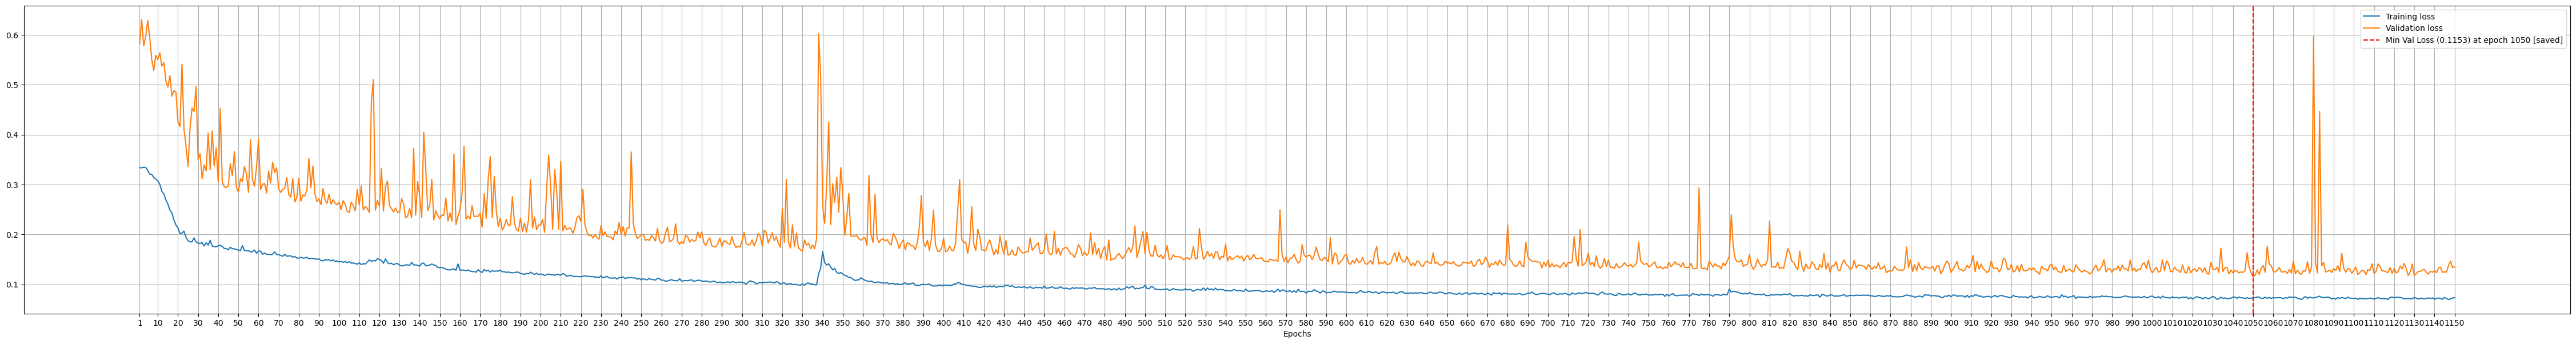

In [17]:
epochs_trained = len(history['train_loss'])
fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1, epochs_trained+1), history['train_loss'], label='Training loss')
plt.plot(np.arange(1, epochs_trained+1), history['val_loss'], label='Validation loss')

min_val_loss = min(history['val_loss'])
min_val_loss_epoch = history['val_loss'].index(min_val_loss) +1
plt.axvline(x=min_val_loss_epoch, color='red', linestyle='--', label=f'Min Val Loss ({min_val_loss:.4f}) at epoch {min_val_loss_epoch} [saved]')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)
#fig.autofmt_xdate()

plt.xlabel("Epochs")
plt.grid(True)
plt.legend()
plt.show()

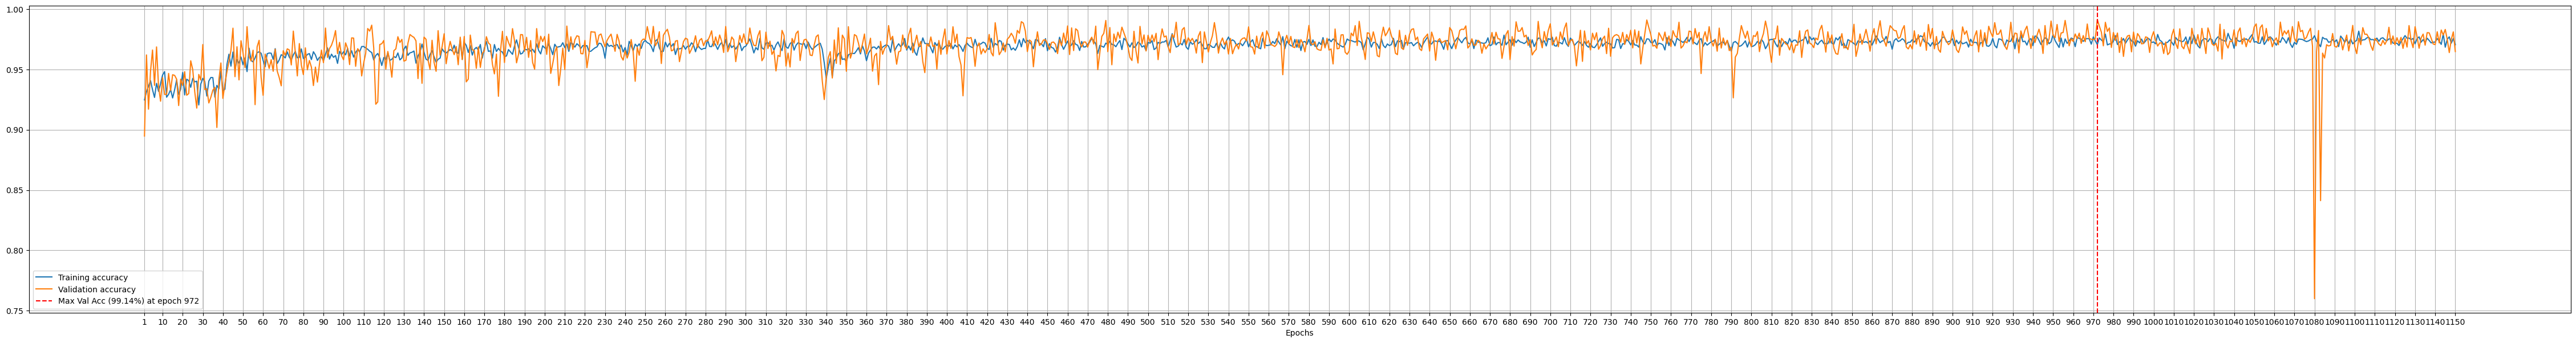

In [18]:
# from tensor to numpy
train_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['train_accuracy']]
val_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['val_accuracy']]
#print(train_accuracy_cpu)

fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1,epochs_trained+1), train_accuracy_cpu, label='Training accuracy')
plt.plot(np.arange(1,epochs_trained+1), val_accuracy_cpu, label='Validation accuracy')

max_val_acc = max(history['val_accuracy'])
max_val_acc_epoch = history['val_accuracy'].index(max_val_acc) +1
plt.axvline(x=max_val_acc_epoch, color='red', linestyle='--', label=f'Max Val Acc ({max_val_acc:.2f}%) at epoch {max_val_acc_epoch}')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)

#fig.autofmt_xdate()
plt.xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

**TEST**

In [ ]:
# create model and load saved state 
# model = ViGUNet(n_channels = NUM_CHANNELS_IN,
#                 n_classes = NUM_CHANNELS_OUT,                 # number of classes to predict
#                 in_features = NUM_CHANNELS_IN * PATCH_SIZE * PATCH_SIZE,       # size of each input patch
#                 out_feature = 192,                                             # features per node/patch (tiny: 192 |small: 320 |base: 640)
#                 num_patches = NUM_PATCHES,
#                 num_ViGBlocks = 12,                                              # number of Grapher module + FFN (tiny: 12 |small: 16 |base: 16)                                      
#                 num_edges = 9,   #9                                              # number of neigbours per node
#                 head_num = 1,    #1
#                 patch_size = PATCH_SIZE,
#                 output_size = IMG_SIZE,
#                 )
# load_model_path = './trained_models/20250205_212939_ViGUNet_0.11527'
# model.load_state_dict(torch.load(load_model_path))
model.to(device)
model.eval()     # !!! set the dropout and batch normalization layers to evaluation mode

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3976\4187686691.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_model_path))


ViGUNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128

In [18]:
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # evaluation at native resolution
    # v2.RandomRotation(degrees=(-180, 180)),
    # v2.RandomHorizontalFlip(),
    # v2.RandomVerticalFlip(),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    # v2.GaussianNoise(),
    # v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 1)),
    #transforms.ToTensor(),    # already tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# load test images
test_img_dir = './data/CHASE/test/images'
test_gt_dir = './data/CHASE/test/2nd_manual'

test_dataset = Dataset(test_img_dir, test_gt_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [19]:
#check test image
for img, gt, img_name in test_loader:
    print(f"Shape of image: {img.shape}")
    print(f"Shape of GT: {gt.shape}")
    print(f"Name of image: {img_name[0]}") 
    break  # just one

Shape of image: torch.Size([1, 3, 512, 512])
Shape of GT: torch.Size([1, 1, 512, 512])
Name of image: 01_test.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


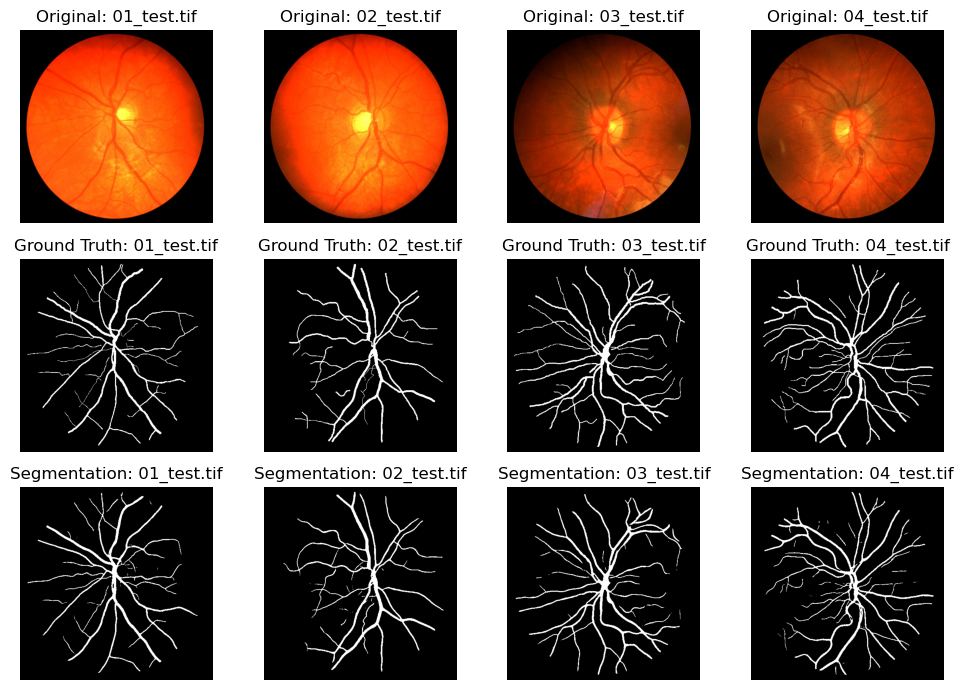

In [20]:
model.eval()   # done before, but just in case...

num_images = 4  # number of images to show
fig, axes = plt.subplots(3, num_images, figsize=(10, 7))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to cuda
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # convert to 0 or 1

        # convert output to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()

        # original test images
        axes[0, i].imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))  # from tensor to image
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original: {image_name[0]}")
        
        # test images ground truth segmentations
        axes[1, i].imshow(gt_img, cmap='gray')  # grayscale
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Ground Truth: {image_name[0]}")

        # test images predicted segmentations
        axes[2, i].imshow(output_img, cmap='gray')  # grayscale
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Segmentation: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

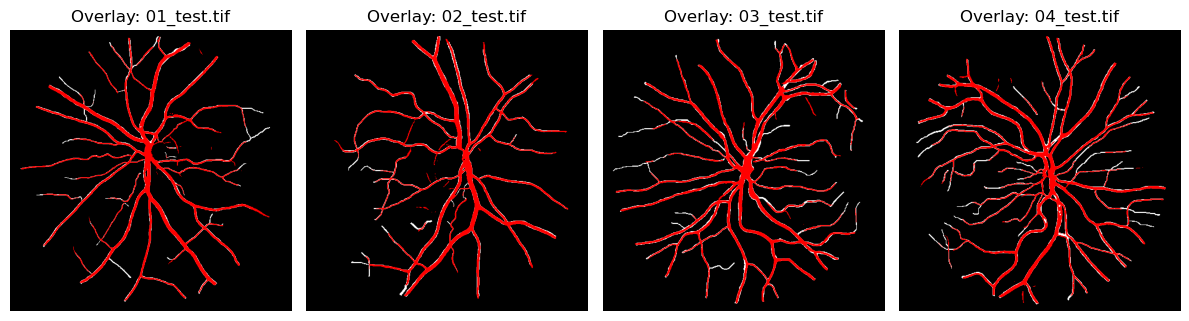

In [21]:
model.eval()   # done before, but just in case...

num_images = 4   # number of images to show
fig, axes = plt.subplots(1, num_images, figsize=(12, 8))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to CUDA
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # binarize prediction

        # convert prediction to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()  # gt as image

        # Mostrar ground truth como fondo en escala de grises
        axes[i].imshow(gt_img, cmap='gray')  # Fondo: ground truth
        
        # Crear imagen RGBA para superponer
        overlay = np.zeros((*output_img.shape, 4))  # Crear un mapa RGBA
        overlay[..., 0] = 1  # Canal rojo
        overlay[..., 3] = output_img  # Canal alfa (0 para transparente, 1 para opaco)
        
        axes[i].imshow(overlay)  # Superposición en RGBA
        
        axes[i].axis('off')
        axes[i].set_title(f"Overlay: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

**ROC, AUC, Test Accuracy, Dice score, MCC, ccDice**


Dice score: 0.8146

MCC: 0.8019

ccDice score: 0.1393

Test Accuracy: 0.9749

F1 Score: 0.8143

Maximum F1 Score: 0.8164 at threshold 0.2782


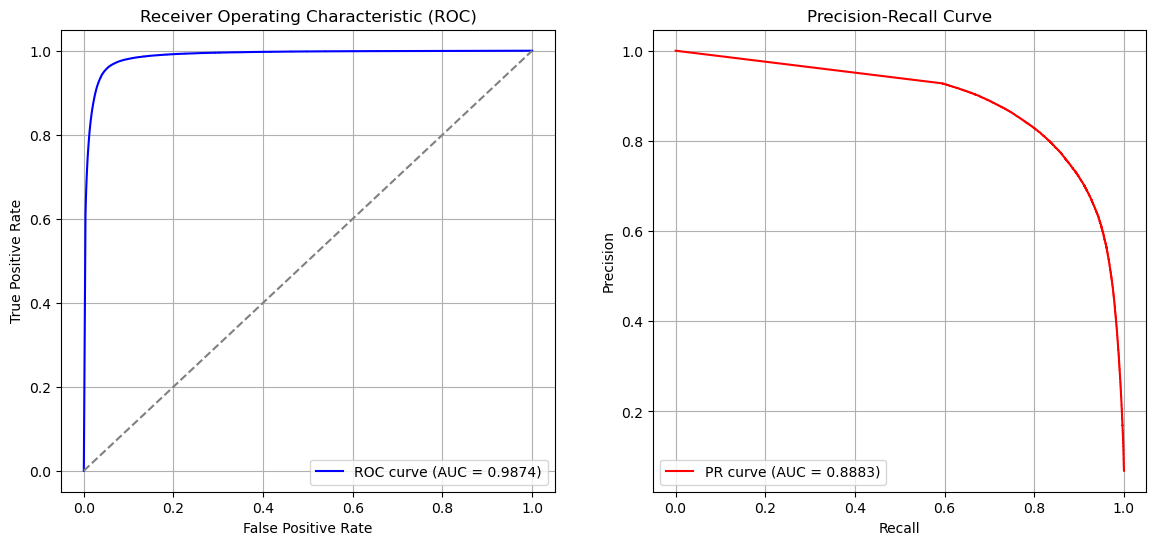

In [24]:
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import torch
from utils.dice_score import dice_score                     # custom function to calculate dice score
from utils.matthews_corr_coef import matthews_corr_coef     # custom function to calculate MCC
from utils.ccDice_score import ccDice                       # modified ccDice score (only binary labels)
from skimage.measure import label                           # necessary for ccDice

calculate_ccdice = True    # yes or no. Forced to use CPU: it takes long to compute (5 minutes just 8 images)

all_labels = []       # to store ground truth values for each pixel of each image
all_preds = []        # to store predicted values for each pixel of each image

dice_score_batches = []       # to store Dice score of each batch
mcc_batches = []              # to store MCC of each batch
if calculate_ccdice:
    ccdice_score_batches = []     # to store ccDice score of each batch

with torch.no_grad():  # no gradients needed
    for inputs, ground_truth, _ in test_loader:        # for each batch in test loader
        inputs = inputs.to(device)
        ground_truth = ground_truth.to(device)

        outputs = model(inputs)     # predict

        all_labels.append(ground_truth.cpu().numpy())       # real labels for each pixel (0 or 1) 
        all_preds.append(outputs.cpu().numpy())             # probabilities to belong to class 1, given by model
        
        dice = dice_score(outputs, ground_truth, threshold=0.5)
        dice_score_batches.append(dice.item())
        
        mcc = matthews_corr_coef(outputs, ground_truth, threshold=0.5)
        mcc_batches.append(mcc)

        if calculate_ccdice:
            y_pred_label, cc_pred = label(((outputs > 0.5).float()).cpu().numpy().squeeze(0), return_num=True)
            y_true_label, cc_true = label(ground_truth.cpu().numpy().squeeze(0), return_num=True)
            ccdice = ccDice(y_pred_label, cc_pred, y_true_label, cc_true, alpha=0.1)    # alpha is level of exigency to join 2 cc (low is permissive, 1.0 is max exigency)
            ccdice_score_batches.append(ccdice)

# compute mean dice score and print
mean_dice_score = torch.tensor(dice_score_batches).mean()
print(f"\nDice score: {mean_dice_score:.4f}")

# compute mean MCC and print
mean_mcc = torch.tensor(mcc_batches).mean()
print(f"\nMCC: {mean_mcc:.4f}")

# compute mean ccDice score and print
if calculate_ccdice:
    mean_ccdice_score = torch.tensor(ccdice_score_batches).mean()
    print(f"\nccDice score: {mean_ccdice_score:.4f}")

# list to numpy array
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# compute mean test accuracy and print
accuracy_sklearn = accuracy_score(list(map(bool, all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nTest Accuracy: {accuracy_sklearn:.4f}")

# compute mean F1 score accuracy and print
f1_sklearn = f1_score(list(map(bool, all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nF1 Score: {f1_sklearn:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(list(map(bool, all_labels.flatten())), all_preds.flatten())     # force labels to binary list

# AUC
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(list(map(bool, all_labels.flatten())), all_preds.flatten())

# AUC-PR
pr_auc = auc(recall, precision)

# Calculate F1 scores for each threshold in the PR curve
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_max = np.max(f1_scores)  # Get the maximum F1 score
f1_max_threshold = thresholds_pr[np.argmax(f1_scores)]  # Get the threshold corresponding to max F1

print(f"\nMaximum F1 Score: {f1_max:.4f} at threshold {f1_max_threshold:.4f}")

# plot ROC and Precision-Recall curves
plt.figure(figsize=(14, 6))

# ROC curve plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)

# Precision-Recall curve plot
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='red', label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)

plt.show()

trained_models\20250205_212939_ViGUNet_0.11527

In [23]:
# just to visualize the model architecture

'''from torch.utils.tensorboard import SummaryWriter
import torchvision

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/UNet')

# get some random training images
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)

print(images.shape)
images = images.to(device)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

#img_grid = img_grid.unsqueeze(0) 

# write to tensorboard
writer.add_image('train_img', img_grid)

writer.add_graph(model, images)
writer.close()

# write in terminal --->   tensorboard --logdir=runs/Unet'''

'from torch.utils.tensorboard import SummaryWriter\nimport torchvision\n\n# default `log_dir` is "runs" - we\'ll be more specific here\nwriter = SummaryWriter(\'runs/UNet\')\n\n# get some random training images\ndataiter = iter(train_loader)\nimages, labels, _ = next(dataiter)\n\nprint(images.shape)\nimages = images.to(device)\n\n# create grid of images\nimg_grid = torchvision.utils.make_grid(images)\n\n#img_grid = img_grid.unsqueeze(0) \n\n# write to tensorboard\nwriter.add_image(\'train_img\', img_grid)\n\nwriter.add_graph(model, images)\nwriter.close()\n\n# write in terminal --->   tensorboard --logdir=runs/Unet'